# Stage 4: Clustering (Unconstrained Exploration)

**Primary author:** Victoria
**Builds on:**
- *Hierarchical_Clustering_Indicators_with_BGE_M3_Embeddings.ipynb* (Victoria — HDBSCAN; Sahana — agglomerative/Ward's)
- *NC_Indicators_wo_Context_Clustered_Embeddings_Compared.ipynb* (Nathan — DBSCAN, EmbeddingComparison framework, silhouette evaluation)
- `03_dimensionality_reduction.ipynb` (Stage 3 output: UMAP embeddings)

**Prompt engineering:** Victoria
**AI assistance:** Claude (Anthropic)
**Environment:** Great Lakes for parameter sweeps, Colab for single runs

**Research question: "What structure emerges when we let the algorithms find it
without guidance?"**

This notebook applies unsupervised clustering to the 10-dimensional UMAP embeddings
of 12,622 verified CCC indicators. We deliberately do NOT use domain knowledge (seed
words, wordplay type labels, or expert-defined categories) to guide clustering here.
The goal is to discover what structure the embedding space reveals on its own.

Two clustering approaches are used:

1. **HDBSCAN** — a density-based method that discovers clusters of varying density
   and automatically determines the number of clusters. Requires an epsilon
   sensitivity analysis (per KCT, Feb 15).
2. **Agglomerative clustering with Ward's method** — a hierarchical method that
   merges clusters bottom-up using global variance statistics. We explore multiple
   values of k (number of clusters) spanning coarse to fine granularity.

Domain knowledge and labeled evaluation are introduced in Notebook 05 (constrained
and targeted experiments) and Notebook 06 (evaluation and report figures).

## Running on Google Colab

If running on Google Colab:

1. Go to **Runtime > Change runtime type**
2. A GPU is not required for clustering, but will speed up UMAP if you need to
   regenerate embeddings
3. Click **Save**, then run all cells

For parameter sweeps (many HDBSCAN runs), Great Lakes is recommended.
Single clustering runs complete in seconds on any hardware.

---
## Section 1: Setup and Data Preparation

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

import hdbscan  # install via: pip install hdbscan

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi'] = 120

np.random.seed(42)

### Environment Auto-Detection and Paths

In [2]:
# --- Environment Auto-Detection ---
try:
    IS_COLAB = 'google.colab' in str(get_ipython())
except NameError:
    IS_COLAB = False

if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT = Path('/content/drive/MyDrive/SIADS 692 Milestone II/Milestone II - NLP Cryptic Crossword Clues')
else:
    try:
        PROJECT_ROOT = Path(__file__).resolve().parent.parent
    except NameError:
        PROJECT_ROOT = Path.cwd().parent

DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'outputs'
FIGURES_DIR = OUTPUT_DIR / 'figures'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f'Project root: {PROJECT_ROOT}')
print(f'Data directory: {DATA_DIR}')
print(f'Output directory: {OUTPUT_DIR}')
print(f'Figures directory: {FIGURES_DIR}')

Project root: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering
Data directory: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/data
Output directory: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs
Figures directory: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures


### Input File Validation

Before proceeding, we verify that all required input files from earlier stages exist.
These are:

| File | Produced by | Description |
|------|-------------|-------------|
| `embeddings_umap_10d.npy` | Stage 3 | 10D UMAP embeddings for clustering |
| `embeddings_umap_2d.npy` | Stage 3 | 2D UMAP embeddings for visualization |
| `indicator_index_all.csv` | Stage 2 | Row-to-indicator-string mapping |

Note: This notebook does NOT load `verified_clues_labeled.csv` (wordplay labels).
Label-based evaluation is deferred to Notebooks 05 and 06.

In [3]:
required_files = {
    'embeddings_umap_10d.npy': 'Run 03_dimensionality_reduction.ipynb (Stage 3)',
    'embeddings_umap_2d.npy': 'Run 03_dimensionality_reduction.ipynb (Stage 3)',
    'indicator_index_all.csv': 'Run 02_embedding_generation.ipynb (Stage 2)',
}

for fname, fix_msg in required_files.items():
    fpath = DATA_DIR / fname
    assert fpath.exists(), (
        f'Missing required file: {fpath}\n'
        f'Fix: {fix_msg}'
    )

print('All input files found:')
for fname in required_files:
    print(f'  {fname}')

All input files found:
  embeddings_umap_10d.npy
  embeddings_umap_2d.npy
  indicator_index_all.csv


### Load Input Files

In [4]:
# Load UMAP embeddings
embeddings_10d = np.load(DATA_DIR / 'embeddings_umap_10d.npy')
embeddings_2d = np.load(DATA_DIR / 'embeddings_umap_2d.npy')

# Load indicator index (maps row i -> indicator string)
df_index = pd.read_csv(DATA_DIR / 'indicator_index_all.csv', index_col=0)
indicator_col = df_index.columns[0]  # should be 'indicator'
indicator_names = df_index[indicator_col].values  # numpy array for fast indexing

print(f'10D embeddings shape: {embeddings_10d.shape}')
print(f'2D embeddings shape:  {embeddings_2d.shape}')
print(f'Indicator index rows: {len(df_index)}')

# Sanity checks
n_indicators = len(df_index)
assert embeddings_10d.shape == (n_indicators, 10), (
    f'Expected 10D shape ({n_indicators}, 10), got {embeddings_10d.shape}'
)
assert embeddings_2d.shape == (n_indicators, 2), (
    f'Expected 2D shape ({n_indicators}, 2), got {embeddings_2d.shape}'
)
print(f'\nShape checks passed: {n_indicators:,} indicators')

10D embeddings shape: (12622, 10)
2D embeddings shape:  (12622, 2)
Indicator index rows: 12622

Shape checks passed: 12,622 indicators


---
## Section 2: Pairwise Distance Analysis

**Why this step is necessary:** HDBSCAN's `cluster_selection_epsilon` parameter defines
a distance threshold below which clusters will be merged. If we choose an epsilon of 0.5
but all pairwise distances in our data are between 0.01 and 0.05, that epsilon is
meaninglessly large — it would merge everything into one cluster. Conversely, an epsilon
of 0.001 in that same data would have no effect. **Without knowing the actual distance
scale, any epsilon choice is arbitrary.**

Following KCT's guidance (Feb 15 meeting): "Take a look at typical pairwise distances,
get a distribution, pick a value of epsilon based on that."

We compute pairwise Euclidean distances on a random sample of 2,000 points from the
10D UMAP embeddings. Using all 12,622 points would produce ~80 million distance pairs
(12,622 × 12,621 / 2), which is computationally expensive. A sample of 2,000 gives
~2 million pairs — more than enough to characterize the distribution.

**Note on distance metric:** HDBSCAN uses Euclidean distance by default, and our 10D
UMAP embeddings were produced with `metric='cosine'` — meaning UMAP already arranged
the points so that cosine-similar items are Euclidean-close in the reduced space. So
Euclidean distance in UMAP space is appropriate here.

In [5]:
# Sample 2,000 points for pairwise distance computation
sample_size = 2000
rng = np.random.RandomState(42)
sample_idx = rng.choice(len(embeddings_10d), size=sample_size, replace=False)
sample_embeddings = embeddings_10d[sample_idx]

# Compute pairwise Euclidean distances (returns condensed form)
# pdist returns a 1D array of all unique pairs
pairwise_dists = pdist(sample_embeddings, metric='euclidean')

print(f'Sample size: {sample_size}')
print(f'Number of pairwise distances: {len(pairwise_dists):,}')
print(f'\nDistance statistics:')
print(f'  Min:    {pairwise_dists.min():.4f}')
print(f'  Max:    {pairwise_dists.max():.4f}')
print(f'  Mean:   {pairwise_dists.mean():.4f}')
print(f'  Median: {np.median(pairwise_dists):.4f}')
print(f'  Std:    {pairwise_dists.std():.4f}')

# Key percentiles — these will guide epsilon selection
percentiles = [5, 10, 25, 50, 75, 90, 95]
percentile_values = np.percentile(pairwise_dists, percentiles)

print(f'\nKey percentiles:')
for p, v in zip(percentiles, percentile_values):
    print(f'  {p:3d}th percentile: {v:.4f}')

Sample size: 2000
Number of pairwise distances: 1,999,000

Distance statistics:
  Min:    0.0025
  Max:    8.5080
  Mean:   3.5617
  Median: 3.5518
  Std:    1.2452

Key percentiles:
    5th percentile: 1.4980
   10th percentile: 1.9327
   25th percentile: 2.6847
   50th percentile: 3.5518
   75th percentile: 4.4582
   90th percentile: 5.2181
   95th percentile: 5.5993


### Distance Distribution Histogram

The histogram below shows the distribution of all pairwise Euclidean distances in the
2,000-point sample. Vertical lines mark key percentiles. The shape of this distribution
tells us:

- **If unimodal and tight:** Most points are at similar distances — the data is
  relatively uniform, and clustering will be sensitive to epsilon.
- **If multimodal or with a long tail:** There are distinct distance scales — some
  points are much closer to each other than to the bulk, suggesting natural clusters.
- **Where the bulk of the distribution sits:** This sets the scale for epsilon selection.

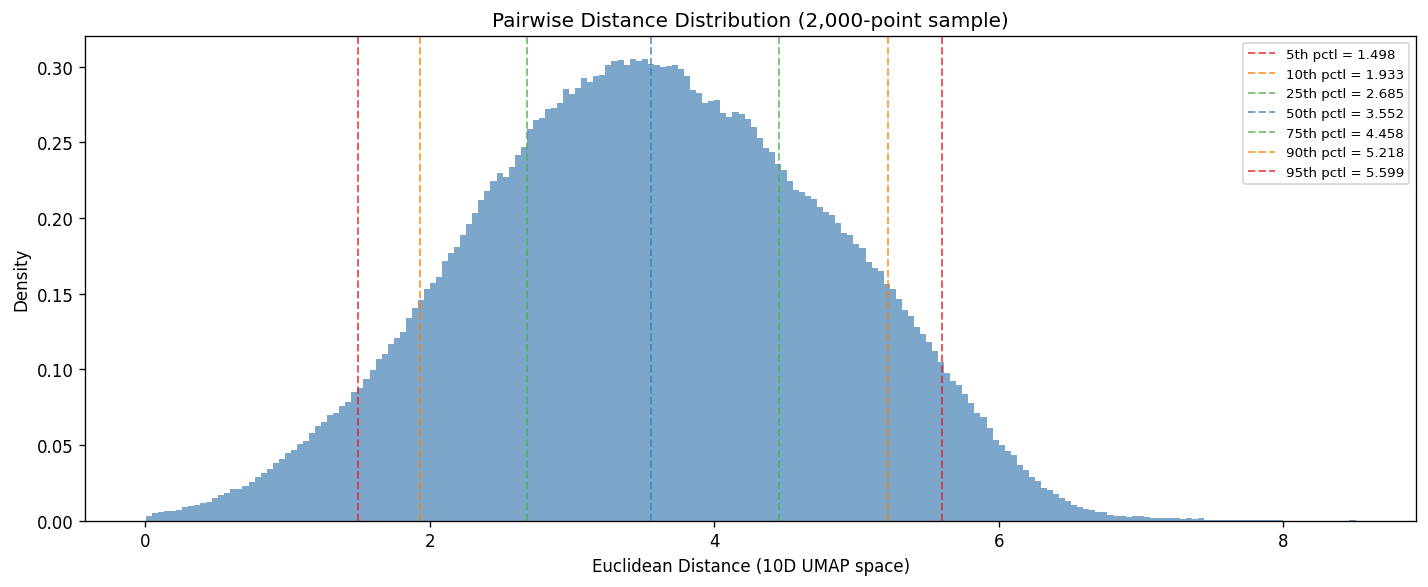

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/pairwise_distance_distribution.png


In [6]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.hist(pairwise_dists, bins=200, color='steelblue', alpha=0.7, edgecolor='none',
        density=True)

# Mark key percentiles
colors_pctl = ['#e41a1c', '#ff7f00', '#4daf4a', '#377eb8', '#4daf4a', '#ff7f00', '#e41a1c']
for p, v, c in zip(percentiles, percentile_values, colors_pctl):
    ax.axvline(v, color=c, linestyle='--', alpha=0.7, linewidth=1.2,
               label=f'{p}th pctl = {v:.3f}')

ax.set_xlabel('Euclidean Distance (10D UMAP space)')
ax.set_ylabel('Density')
ax.set_title('Pairwise Distance Distribution (2,000-point sample)')
ax.legend(fontsize=8, loc='upper right')

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'pairwise_distance_distribution.png', dpi=150,
            bbox_inches='tight')
plt.show()

print(f'Saved: {FIGURES_DIR / "pairwise_distance_distribution.png"}')

---
## Section 3: HDBSCAN with Epsilon Sensitivity Analysis

### What is HDBSCAN?

**HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)**
is a density-based clustering algorithm. Unlike k-means, it does not require the number
of clusters to be specified in advance — it discovers clusters of varying density
automatically. Points in low-density regions are labeled as "noise" (cluster label = -1)
rather than being forced into the nearest cluster.

### Key Parameters

- **`min_cluster_size`** — The minimum number of points required to form a cluster.
  We use 10, meaning any group of fewer than 10 nearby indicators is treated as noise
  rather than a cluster. This prevents tiny, meaningless clusters.

- **`cluster_selection_epsilon`** — A distance threshold for cluster merging. When two
  clusters are closer than epsilon, HDBSCAN merges them into one. Larger epsilon values
  produce fewer, larger clusters; smaller values produce more, finer-grained clusters.
  **This is the parameter we will sweep** across values informed by the distance
  distribution in Section 2.

### Interpreting the Sensitivity Analysis

We run HDBSCAN at several epsilon values and track:
- **Number of clusters found** — How granularity changes with epsilon
- **Noise percentage** — How many points are left unassigned
- **Silhouette score** — Measures how similar each point is to its own cluster vs.
  the nearest other cluster (-1 to 1; higher is better). Computed on non-noise
  points only.
- **Davies-Bouldin index** — Measures the average similarity between each cluster
  and its most similar cluster (lower is better).

**Stability interpretation:** If metrics change dramatically with small epsilon changes,
the cluster structure is **fragile** — it depends sensitively on a parameter choice
rather than reflecting genuine structure. If metrics are stable across a range of epsilon
values, the structure is **robust** and we can be more confident in the results.

### Select Epsilon Candidates

We choose epsilon candidates based on the distance distribution percentiles computed
above. The candidates span from 0.0 (no merging) to the 25th percentile.

Because the initial sweep showed a dramatic jump from ~282 clusters at epsilon=0 to
~11 clusters at the 1st percentile (~0.78), we add **finer resolution in the
0-to-5th-percentile range**. Six evenly spaced values between 0 and the 5th percentile
fill in the critical transition zone where most cluster merging happens. The remaining
candidates (5th through 25th percentile) use coarser spacing since the clustering has
already stabilized by that point.

In [7]:
# The 5th percentile marks the upper bound of the critical transition zone
p5 = float(np.percentile(pairwise_dists, 5))

# Fine-grained candidates: 6 evenly spaced values between 0 and the 5th percentile.
# These fill in the gap where HDBSCAN transitions from many small clusters to few
# large ones. np.linspace(0, p5, 8) gives 8 points including both endpoints;
# we take the 6 interior values since 0 and p5 appear in other lists.
fine_eps = list(np.linspace(0, p5, 8)[1:-1])

# Coarse candidates from percentiles (1st through 25th)
coarse_eps = [
    float(np.percentile(pairwise_dists, 1)),
    float(np.percentile(pairwise_dists, 5)),
    float(np.percentile(pairwise_dists, 10)),
    float(np.percentile(pairwise_dists, 15)),
    float(np.percentile(pairwise_dists, 20)),
    float(np.percentile(pairwise_dists, 25)),
]

# Combine: 0.0 + fine-grained + coarse, then deduplicate and sort
all_eps = [0.0] + fine_eps + coarse_eps
epsilon_candidates = sorted(set(float(round(e, 4)) for e in all_eps))

print(f'5th percentile distance: {p5:.4f}')
print(f'\nEpsilon candidates for HDBSCAN sweep ({len(epsilon_candidates)} values):')
for i, eps in enumerate(epsilon_candidates):
    zone = '(fine)' if 0 < eps < p5 else '(percentile)' if eps >= p5 else '(baseline)'
    print(f'  {i+1:2d}. epsilon = {eps:.4f}  {zone}')

5th percentile distance: 1.4980

Epsilon candidates for HDBSCAN sweep (13 values):
   1. epsilon = 0.0000  (baseline)
   2. epsilon = 0.2140  (fine)
   3. epsilon = 0.4280  (fine)
   4. epsilon = 0.6420  (fine)
   5. epsilon = 0.7788  (fine)
   6. epsilon = 0.8560  (fine)
   7. epsilon = 1.0700  (fine)
   8. epsilon = 1.2840  (fine)
   9. epsilon = 1.4980  (percentile)
  10. epsilon = 1.9327  (percentile)
  11. epsilon = 2.2334  (percentile)
  12. epsilon = 2.4729  (percentile)
  13. epsilon = 2.6847  (percentile)


### Run HDBSCAN Sweep

For each epsilon value, we run HDBSCAN on the 10D UMAP embeddings and record
clustering metrics. Silhouette and Davies-Bouldin scores are computed on non-noise
points only (since noise points have no cluster assignment). This is standard practice
but means that a run with very high noise (few clustered points) can have a deceptively
high silhouette score — we must examine noise percentage alongside silhouette.

In [8]:
hdbscan_results = []
hdbscan_labels_dict = {}  # store labels for each epsilon

for eps in epsilon_candidates:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=10,
        cluster_selection_epsilon=eps,
        metric='euclidean',
        core_dist_n_jobs=-1,
    )
    labels = clusterer.fit_predict(embeddings_10d)
    hdbscan_labels_dict[eps] = labels

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    noise_pct = n_noise / len(labels) * 100

    # Compute metrics on non-noise points only
    non_noise_mask = labels != -1
    n_clustered = non_noise_mask.sum()

    if n_clusters >= 2 and n_clustered >= 2:
        sil = silhouette_score(embeddings_10d[non_noise_mask], labels[non_noise_mask])
        db = davies_bouldin_score(embeddings_10d[non_noise_mask], labels[non_noise_mask])
    else:
        sil = float('nan')
        db = float('nan')

    hdbscan_results.append({
        'epsilon': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_pct': noise_pct,
        'n_clustered': n_clustered,
        'silhouette': sil,
        'davies_bouldin': db,
    })

    print(f'eps={eps:.4f}: {n_clusters:4d} clusters, '
          f'{n_noise:5d} noise ({noise_pct:5.1f}%), '
          f'silhouette={sil:.3f}, DB={db:.3f}')

df_hdbscan = pd.DataFrame(hdbscan_results)
print('\n--- HDBSCAN Sweep Summary ---')
print(df_hdbscan.to_string(index=False))

eps=0.0000:  282 clusters,  4212 noise ( 33.4%), silhouette=0.631, DB=0.470
eps=0.2140:  244 clusters,  3783 noise ( 30.0%), silhouette=0.584, DB=0.509
eps=0.4280:   62 clusters,  1306 noise ( 10.3%), silhouette=-0.118, DB=1.048
eps=0.6420:   17 clusters,   313 noise (  2.5%), silhouette=-0.296, DB=0.977
eps=0.7788:   11 clusters,   114 noise (  0.9%), silhouette=-0.186, DB=0.775
eps=0.8560:   10 clusters,    28 noise (  0.2%), silhouette=-0.168, DB=0.798
eps=1.0700:    6 clusters,     0 noise (  0.0%), silhouette=-0.120, DB=0.782
eps=1.2840:    6 clusters,     0 noise (  0.0%), silhouette=-0.120, DB=0.782
eps=1.4980:    4 clusters,     0 noise (  0.0%), silhouette=0.230, DB=0.549
eps=1.9327:    4 clusters,     0 noise (  0.0%), silhouette=0.230, DB=0.549
eps=2.2334:    3 clusters,     0 noise (  0.0%), silhouette=0.386, DB=0.461
eps=2.4729:    3 clusters,     0 noise (  0.0%), silhouette=0.386, DB=0.461
eps=2.6847:    3 clusters,     0 noise (  0.0%), silhouette=0.386, DB=0.461

--- H

### Sensitivity Plot

The plot below shows how three key metrics change as epsilon increases. This is the
sensitivity analysis KCT requested. We look for:

- **Stable regions:** Where metrics plateau, indicating robust structure
- **Sharp transitions:** Where a small epsilon change causes large metric jumps,
  indicating fragile structure at that scale
- **Trade-offs:** More clusters typically means more noise points but potentially
  higher silhouette (tighter individual clusters)

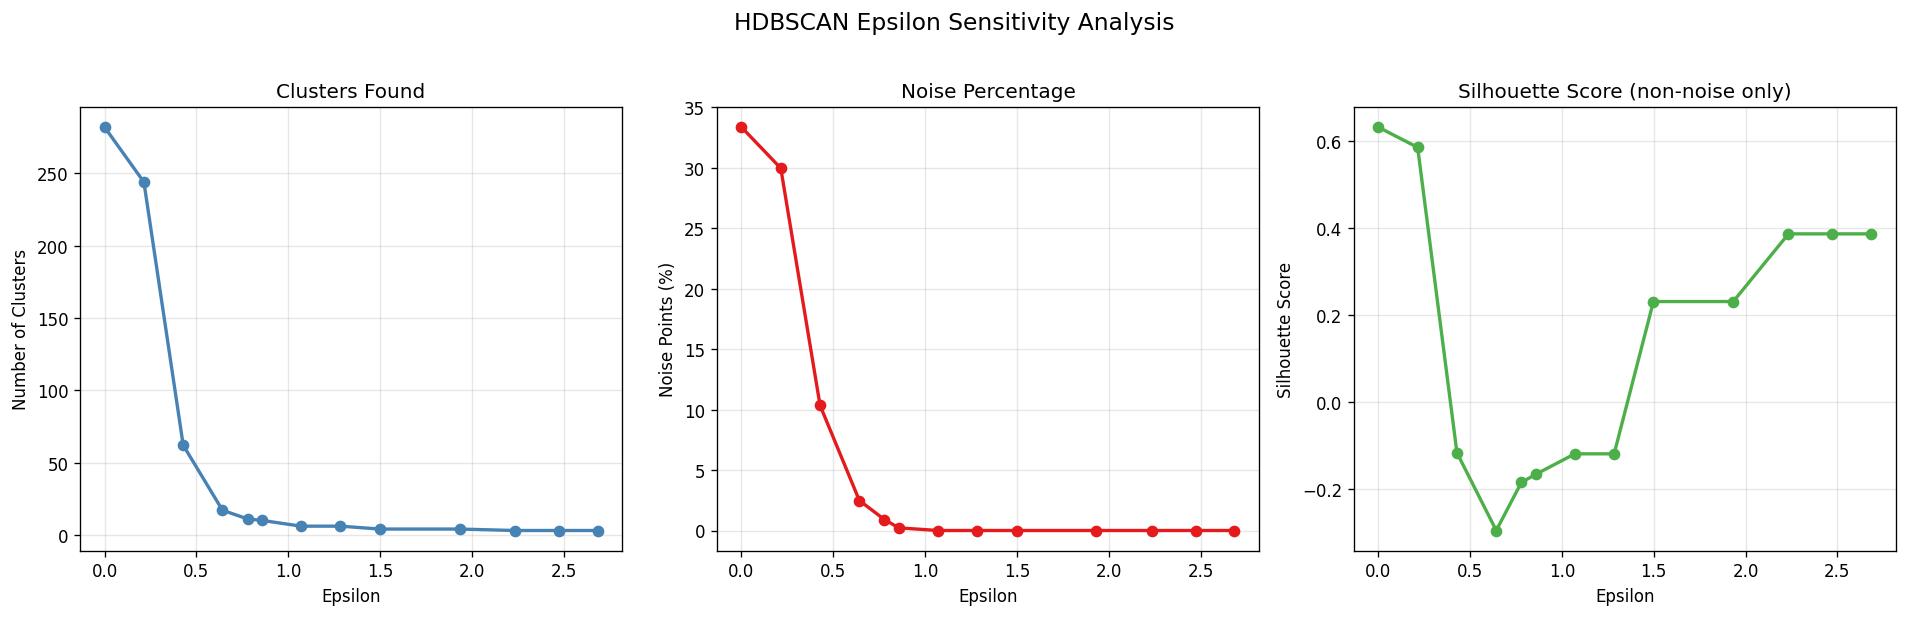

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/hdbscan_epsilon_sensitivity.png


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Number of clusters
axes[0].plot(df_hdbscan['epsilon'], df_hdbscan['n_clusters'],
             'o-', color='steelblue', linewidth=2, markersize=6)
axes[0].set_xlabel('Epsilon')
axes[0].set_ylabel('Number of Clusters')
axes[0].set_title('Clusters Found')
axes[0].grid(True, alpha=0.3)

# Panel 2: Noise percentage
axes[1].plot(df_hdbscan['epsilon'], df_hdbscan['noise_pct'],
             'o-', color='#e41a1c', linewidth=2, markersize=6)
axes[1].set_xlabel('Epsilon')
axes[1].set_ylabel('Noise Points (%)')
axes[1].set_title('Noise Percentage')
axes[1].grid(True, alpha=0.3)

# Panel 3: Silhouette score
axes[2].plot(df_hdbscan['epsilon'], df_hdbscan['silhouette'],
             'o-', color='#4daf4a', linewidth=2, markersize=6)
axes[2].set_xlabel('Epsilon')
axes[2].set_ylabel('Silhouette Score')
axes[2].set_title('Silhouette Score (non-noise only)')
axes[2].grid(True, alpha=0.3)

plt.suptitle('HDBSCAN Epsilon Sensitivity Analysis', fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'hdbscan_epsilon_sensitivity.png', dpi=150,
            bbox_inches='tight')
plt.show()

print(f'Saved: {FIGURES_DIR / "hdbscan_epsilon_sensitivity.png"}')

### Identify Best HDBSCAN Run

We select the HDBSCAN run with the highest silhouette score as the "best" run for
visualization and qualitative inspection later in this notebook. This is a pragmatic
choice — silhouette score is not the only criterion, and we save all runs so that
Notebook 05 can compare them more thoroughly.

In [10]:
best_hdbscan_idx = df_hdbscan['silhouette'].idxmax()
best_hdbscan_row = df_hdbscan.loc[best_hdbscan_idx]
best_eps = best_hdbscan_row['epsilon']
best_hdbscan_labels = hdbscan_labels_dict[best_eps]

print(f'Best HDBSCAN run by silhouette score:')
print(f'  Epsilon:    {best_eps}')
print(f'  Clusters:   {int(best_hdbscan_row["n_clusters"])}')
print(f'  Noise:      {int(best_hdbscan_row["n_noise"])} ({best_hdbscan_row["noise_pct"]:.1f}%)')
print(f'  Silhouette: {best_hdbscan_row["silhouette"]:.3f}')
print(f'  Davies-Bouldin: {best_hdbscan_row["davies_bouldin"]:.3f}')

Best HDBSCAN run by silhouette score:
  Epsilon:    0.0
  Clusters:   282
  Noise:      4212 (33.4%)
  Silhouette: 0.631
  Davies-Bouldin: 0.470


---
## Section 4: Agglomerative Clustering with Ward's Method

### Why Ward's Method?

**Agglomerative clustering** is a bottom-up hierarchical method: each point starts as
its own cluster, and pairs of clusters are merged iteratively until the desired number
of clusters (k) is reached.

**Ward's linkage** minimizes the total within-cluster variance at each merge step. As
KCT recommended (Feb 15 meeting): "Use Ward's method. It uses more global statistics
about the cluster, so doesn't form strange elongated clusters." Unlike single-linkage
(which can chain together distant points through intermediate neighbors) or average-
linkage (which can produce uneven cluster sizes), Ward's method produces compact,
roughly spherical clusters.

### Two-Part Strategy

Unlike HDBSCAN, agglomerative clustering requires the number of clusters (k) to be
specified. Since we don't know what granularity best fits this data, we use a two-part
approach:

**Part A: Metric sweep across a broad range of k.** We run agglomerative clustering
for 15 k values from k=4 (very coarse) to k=250 (very fine) and track how silhouette,
Davies-Bouldin, and Calinski-Harabasz scores change. This is the agglomerative
equivalent of the HDBSCAN epsilon sweep — we look for an "elbow" or plateau where
increasing k stops improving the metrics.

**Part B: Detailed inspection at selected k values.** Based on the metrics sweep, we
select 3 k values for scatter plots and qualitative inspection: k=8 as a reference
point, the k where silhouette peaks, and a fine-grained comparison value. This keeps
the notebook readable without generating 15 scatter plots.

Some of these k values happen to correspond to expert-defined frameworks for CCC
wordplay types (e.g., 8 matches the number of labeled types in the Ho dataset). That
correspondence is noted but is not the reason for choosing them here — we are asking
what the data shows, not testing a specific theory. The connection between our
unconstrained clusters and expert categories will be explored in Notebook 05.

### Part A: Full Metric Sweep

In [11]:
k_values = [4, 6, 8, 9, 10, 11, 12, 16, 20, 26, 34, 50, 75, 100, 150, 200, 250]

agglo_results = []
agglo_labels_dict = {}

for k in k_values:
    clusterer = AgglomerativeClustering(
        n_clusters=k,
        linkage='ward',
    )
    labels = clusterer.fit_predict(embeddings_10d)
    agglo_labels_dict[k] = labels

    sil = silhouette_score(embeddings_10d, labels)
    db = davies_bouldin_score(embeddings_10d, labels)
    ch = calinski_harabasz_score(embeddings_10d, labels)

    agglo_results.append({
        'k': k,
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch,
    })

    print(f'k={k:>3d}: silhouette={sil:.3f}, DB={db:.3f}, CH={ch:.0f}')

df_agglo = pd.DataFrame(agglo_results)
print('\n--- Agglomerative Clustering Metric Sweep ---')
print(df_agglo.to_string(index=False))

k=  4: silhouette=0.246, DB=1.456, CH=3909
k=  6: silhouette=0.259, DB=1.323, CH=3921
k=  8: silhouette=0.272, DB=1.267, CH=3897
k=  9: silhouette=0.289, DB=1.185, CH=3844
k= 10: silhouette=0.299, DB=1.164, CH=3789
k= 11: silhouette=0.281, DB=1.184, CH=3655
k= 12: silhouette=0.281, DB=1.226, CH=3552
k= 16: silhouette=0.279, DB=1.275, CH=3320
k= 20: silhouette=0.295, DB=1.194, CH=3203
k= 26: silhouette=0.304, DB=1.172, CH=3072
k= 34: silhouette=0.322, DB=1.068, CH=2993
k= 50: silhouette=0.344, DB=1.011, CH=2944
k= 75: silhouette=0.370, DB=1.003, CH=2839
k=100: silhouette=0.378, DB=0.978, CH=2787
k=150: silhouette=0.388, DB=0.959, CH=2734
k=200: silhouette=0.419, DB=0.890, CH=2745
k=250: silhouette=0.431, DB=0.884, CH=2802

--- Agglomerative Clustering Metric Sweep ---
  k  silhouette  davies_bouldin  calinski_harabasz
  4    0.246021        1.456096        3909.220873
  6    0.259034        1.322581        3920.874006
  8    0.272435        1.267374        3897.154308
  9    0.288711   

### Interpreting the Metrics

- **Silhouette score** (-1 to 1): Higher means points are well-matched to their own
  cluster and poorly matched to neighboring clusters. Scores above 0.3 suggest
  reasonable structure; above 0.5 is strong.
- **Davies-Bouldin index** (0 to ∞): Lower is better. Measures the average ratio of
  within-cluster scatter to between-cluster separation. A score below 1.0 means
  clusters are more separated than they are scattered.
- **Calinski-Harabasz index** (0 to ∞): Higher is better. Ratio of between-cluster
  dispersion to within-cluster dispersion. Tends to favor larger k values, so
  interpret with caution.

Note that agglomerative clustering assigns every point to a cluster (no noise points),
which makes its silhouette scores directly comparable across k values but not directly
comparable to HDBSCAN (which excludes noise points from the calculation).

### Metrics vs. k: Finding the Data's Preferred Granularity

The table above shows the raw metric values. The plot below visualizes the trends,
making it easier to spot an **elbow** — a point where increasing k stops meaningfully
improving the metrics. The k at the elbow is the data's "preferred granularity."

**If there is no elbow** and metrics keep improving monotonically, that tells us the
data's natural structure is very fine-grained — there is no single k that captures a
"natural" number of clusters. This is itself a meaningful finding.

**A note on Calinski-Harabasz:** This metric has a known bias toward *fewer* clusters.
It measures the ratio of between-cluster to within-cluster dispersion, and this ratio
tends to decrease as k grows (even when clusters are genuinely distinct) because more
clusters mechanically reduce between-cluster distances. Calinski-Harabasz may therefore
show a different pattern than silhouette and Davies-Bouldin — peaking at a smaller k.
This does not necessarily mean fewer clusters are better; it reflects the metric's
structural bias.

### Part B: Selected k Values

After examining the metrics plot, we select **four k values** for detailed visualization
and qualitative inspection:

1. **k=8** — a coarse reference point. This happens to match the number of labeled
   wordplay types in the Ho dataset, but that coincidence is not the reason for
   choosing it here. At this granularity we can see whether the data naturally forms
   a small number of broad groups.
2. **k=10** — a local silhouette optimum. The metrics sweep shows a silhouette bump
   near k=10 before a dip around k=11–12, suggesting this is a locally preferred
   granularity for the data.
3. **k=34** — a mid-range value that bridges the gap between the coarse reference
   and the fine-grained endpoint. This is also the k used for the centroid dendrogram
   (Approach B), so choosing it here allows direct cross-reference between the
   dendrogram structure and the scatter plot.
4. **k=250** — the fine-grained endpoint. At this granularity, clusters should be
   small and semantically tight. Comparing k=250 to k=8 shows how cluster coherence
   changes across the full range.

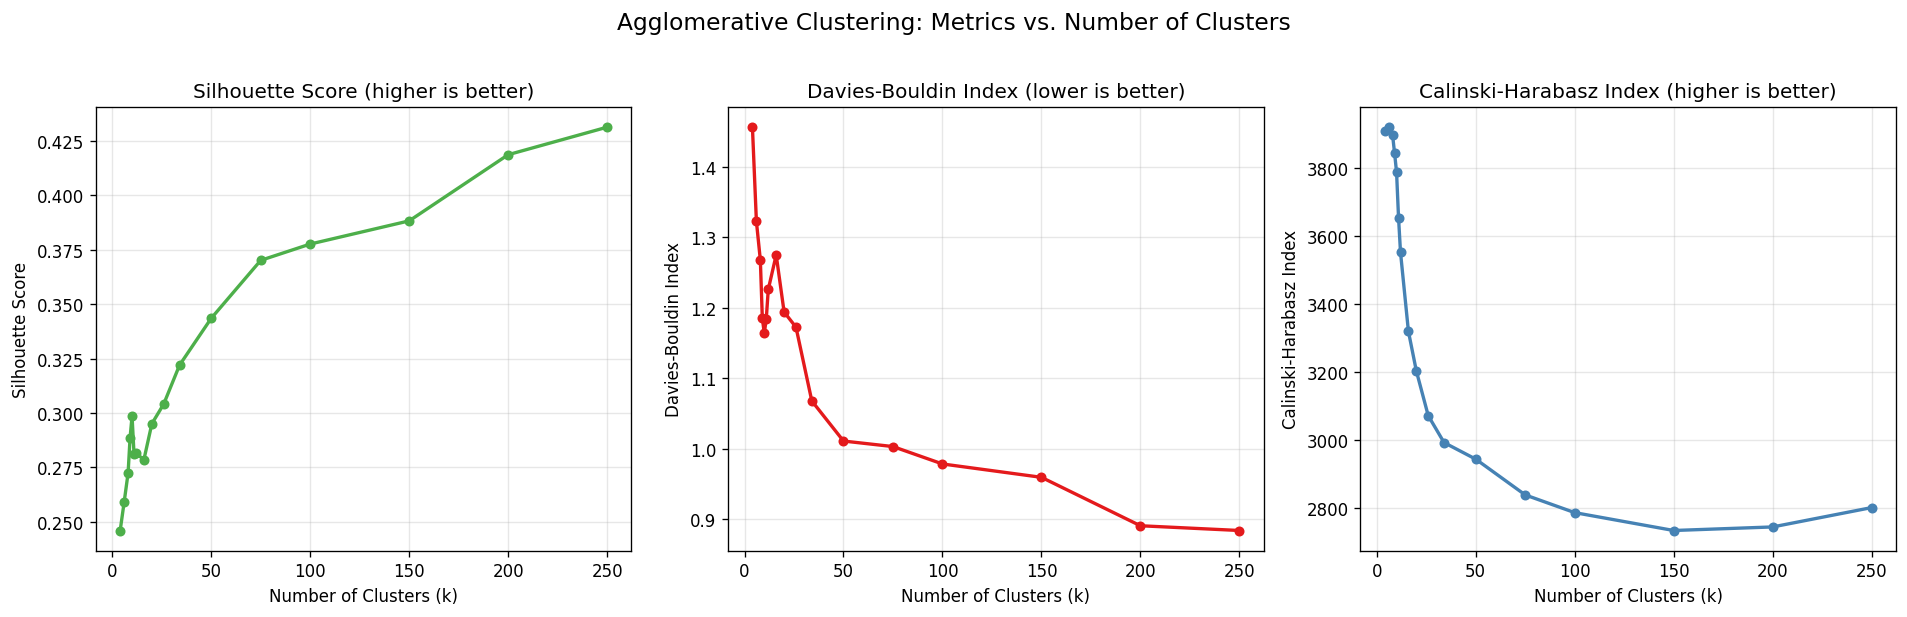

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/agglo_metrics_vs_k.png

Selected k values for detailed inspection:
  k=  8: silhouette=0.272, DB=1.267, CH=3897
  k= 10: silhouette=0.299, DB=1.164, CH=3789
  k= 34: silhouette=0.322, DB=1.068, CH=2993
  k=250: silhouette=0.431, DB=0.884, CH=2802


In [12]:
# --- Metrics-vs-k plot (agglomerative equivalent of HDBSCAN sensitivity analysis) ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].plot(df_agglo['k'], df_agglo['silhouette'],
             'o-', color='#4daf4a', linewidth=2, markersize=5)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score (higher is better)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_agglo['k'], df_agglo['davies_bouldin'],
             'o-', color='#e41a1c', linewidth=2, markersize=5)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_title('Davies-Bouldin Index (lower is better)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df_agglo['k'], df_agglo['calinski_harabasz'],
             'o-', color='steelblue', linewidth=2, markersize=5)
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Calinski-Harabasz Index')
axes[2].set_title('Calinski-Harabasz Index (higher is better)')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Agglomerative Clustering: Metrics vs. Number of Clusters',
             fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'agglo_metrics_vs_k.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {FIGURES_DIR / "agglo_metrics_vs_k.png"}')

# --- Part B: Fixed selection of k values for detailed inspection ---
# k=8  : coarse reference point
# k=10 : local silhouette optimum
# k=34 : mid-range, cross-references with centroid dendrogram
# k=250: fine-grained endpoint
selected_k_values = [8, 10, 34, 250]

print(f'\nSelected k values for detailed inspection:')
for k in selected_k_values:
    row = df_agglo[df_agglo['k'] == k].iloc[0]
    print(f'  k={k:>3d}: silhouette={row["silhouette"]:.3f}, '
          f'DB={row["davies_bouldin"]:.3f}, CH={row["calinski_harabasz"]:.0f}')

### Dendrogram Visualization

A **dendrogram** is a tree diagram that shows how clusters merge in hierarchical
clustering. Each leaf at the bottom represents a data point (or, in a truncated view,
a pre-formed group). The Y axis shows the **merge distance** — the Ward's linkage
distance at which two clusters were combined. Higher merge distances mean the clusters
being merged were more dissimilar.

**How to read a dendrogram:**
- The height of each horizontal line shows the distance at which a merge happened
- A **natural cut point** appears as a large gap between successive merge heights —
  if clusters merge at distances 2.0, 2.1, 2.2, then suddenly at 5.0, the gap
  between 2.2 and 5.0 suggests that the clusters below the gap are more "natural"
  than the merged result above it
- The number of vertical lines crossing a horizontal cut gives the number of clusters
  at that distance threshold

**Why this is useful:** Instead of guessing k values for agglomerative clustering,
the dendrogram shows us what k values are "natural" for the data — where the biggest
jumps in merge distance occur. KCT (Feb 8 and Feb 15 meetings): "Hierarchical
clustering gives you a tree... Y axis of a dendrogram is the merge distance. If you
set the distance big, you get higher level clusters."

We produce multiple dendrograms:

**Approach A: Truncated dendrogram (full data).** We compute the Ward's linkage on all
12,622 indicators and show only the last 50 merges. This reveals the top-level merge
structure — the final and most costly merges before everything collapses into a single
cluster.

**Approach B: Dendrogram of k=34 cluster centroids.** After running agglomerative at
k=34, we compute the centroid of each cluster, then build a dendrogram of those 34
centroids. This shows how the 34 fine-grained clusters would merge into coarser groups
and is much more readable than the full dendrogram.

**Approach C: Centroid dendrograms for other selected k values.** For each selected
k value other than 34, we compute cluster centroids and build an additional dendrogram.
This shows how the hierarchical merge structure varies with granularity — a k=10
centroid dendrogram reveals top-level groupings, while a k=250 dendrogram reveals
fine-grained merge patterns.

Computing Ward linkage on all indicators (this may take a minute)...
Linkage matrix shape: (12621, 4)
Final merge distance: 229.76


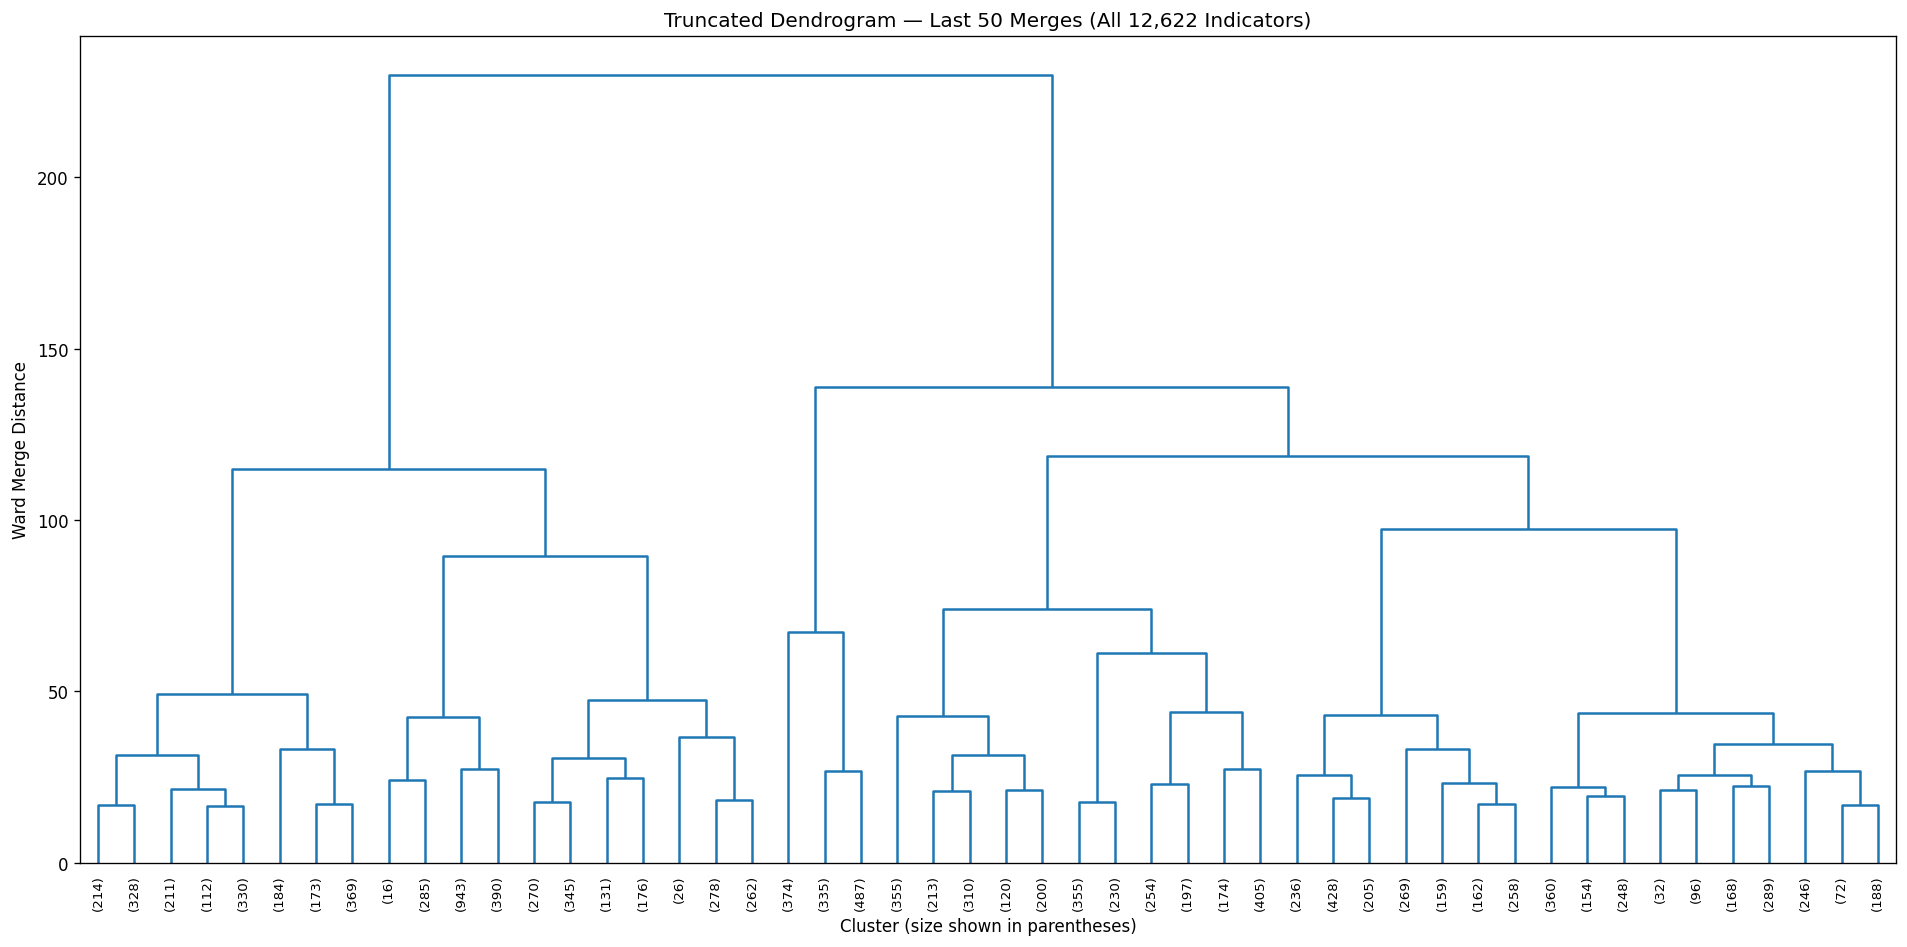

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/dendrogram_truncated_top50.png

Centroid matrix shape: (34, 10)


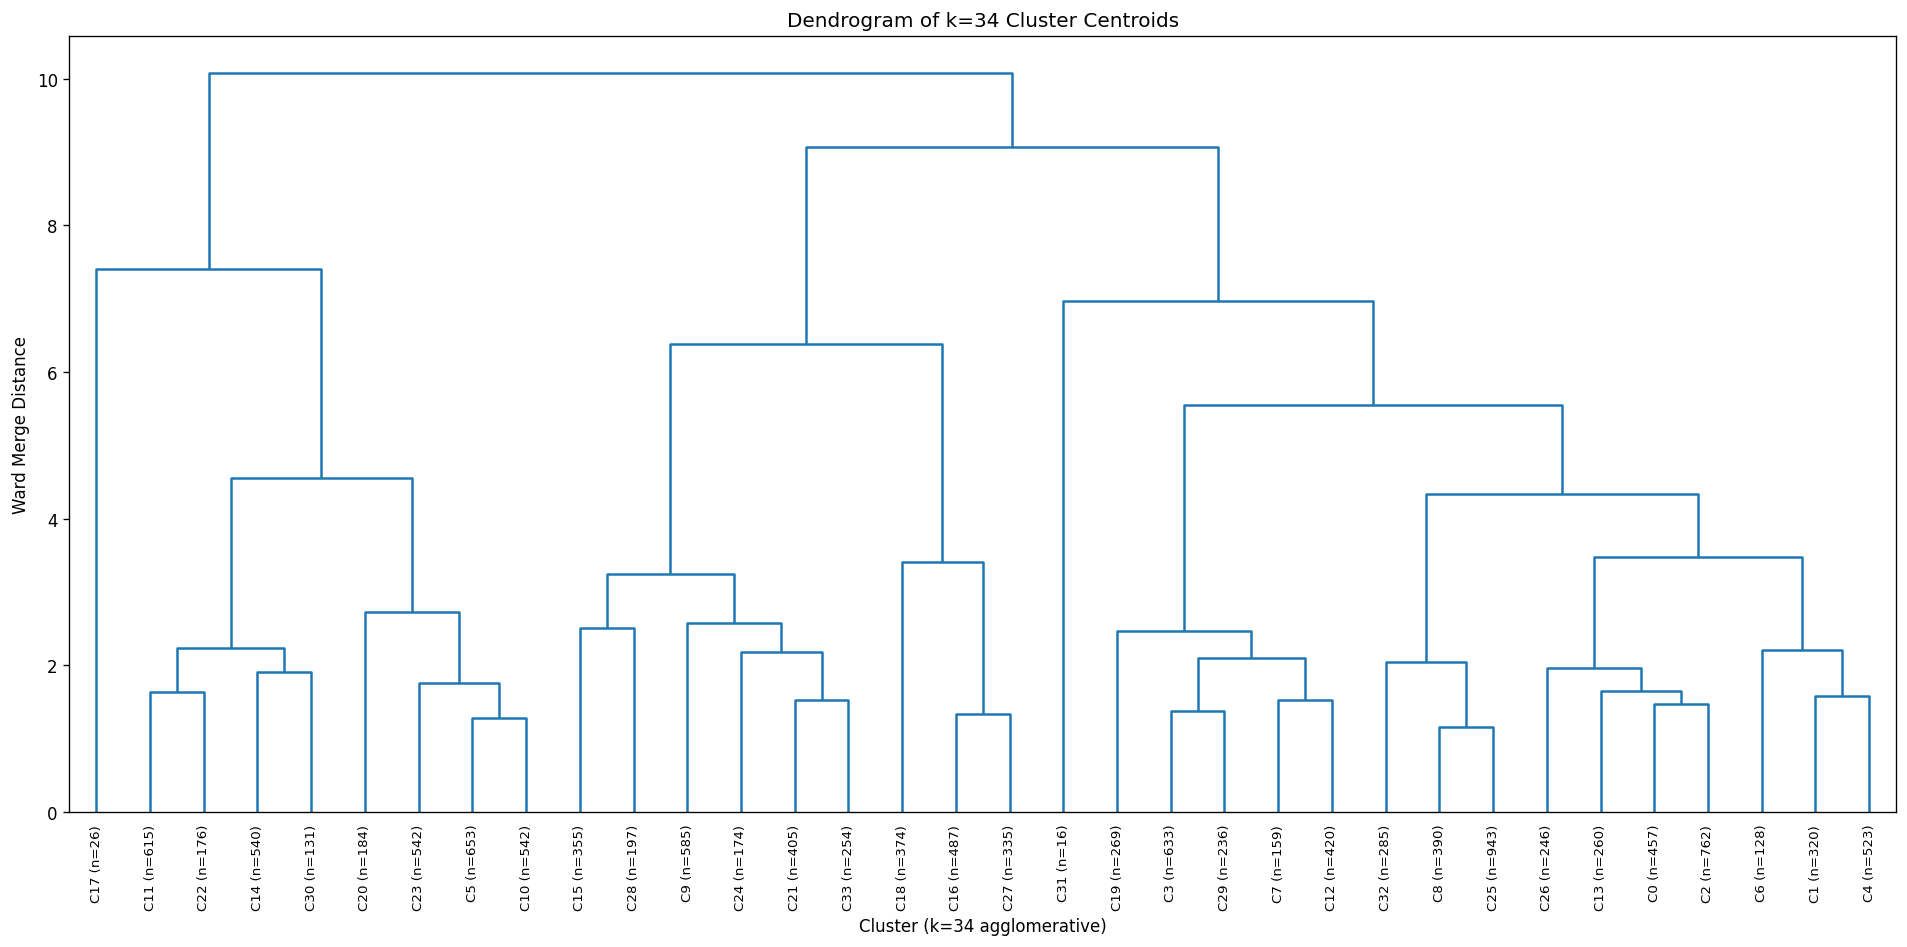

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/dendrogram_k34_centroids.png


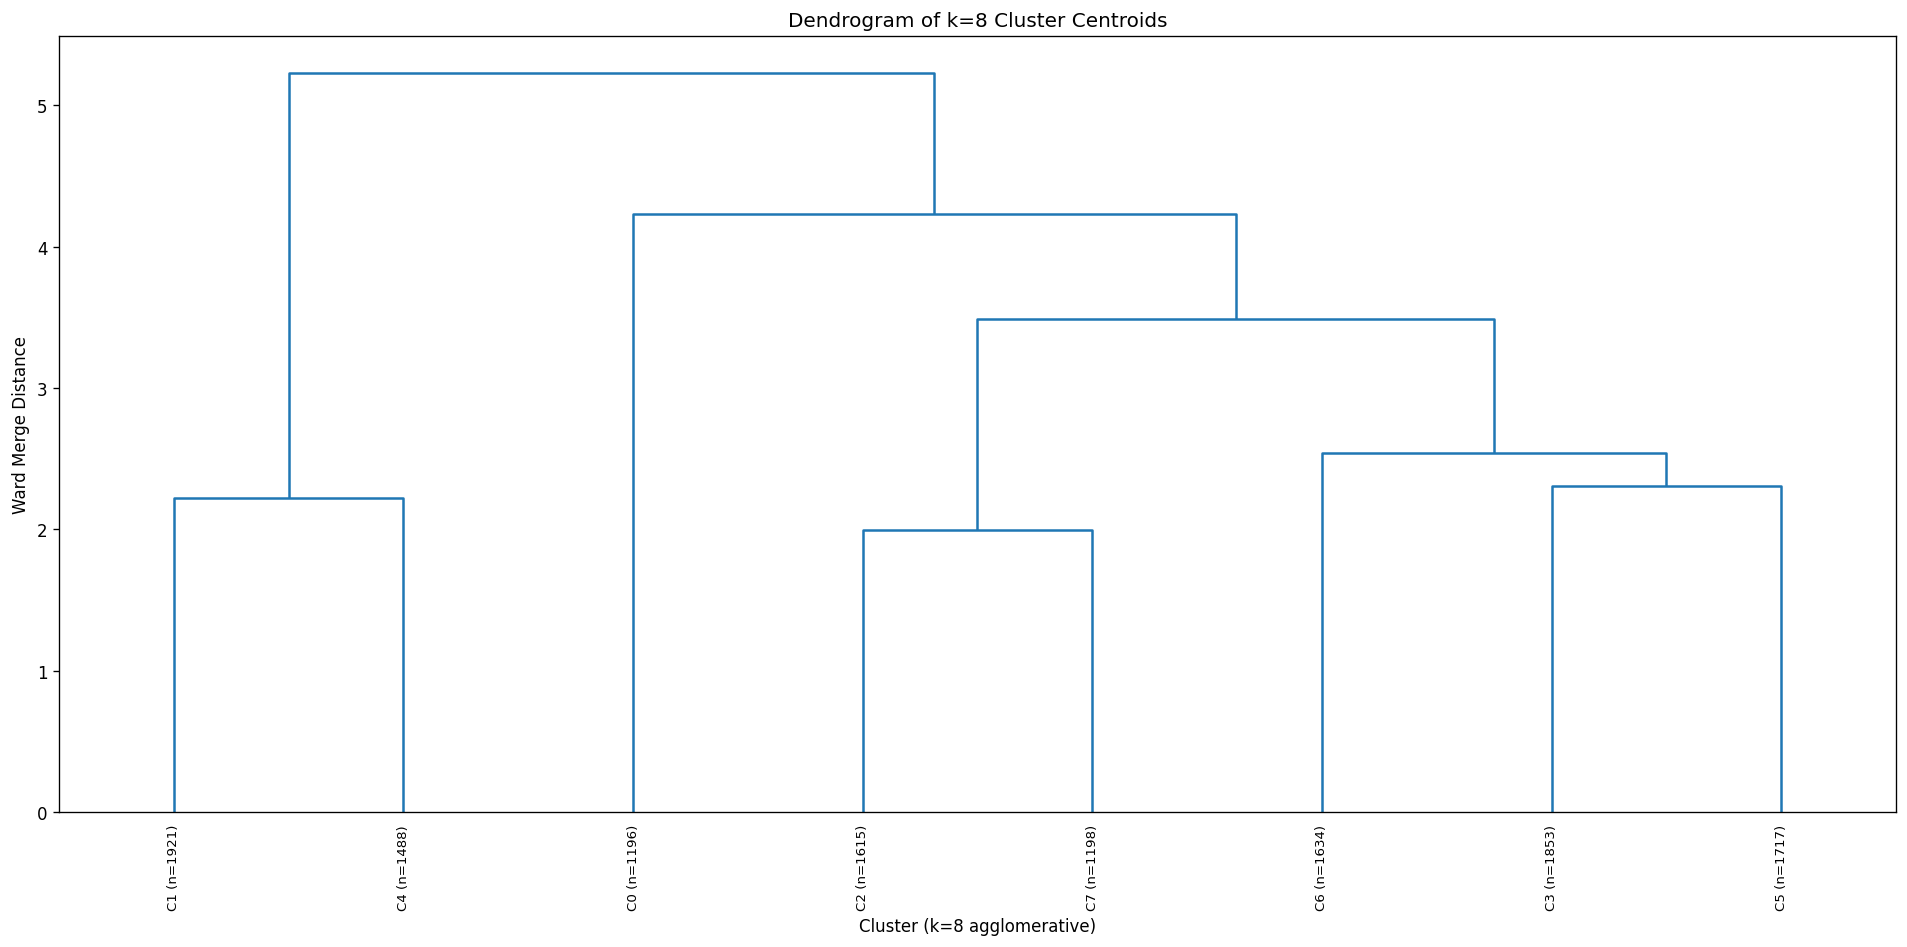

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/dendrogram_k8_centroids.png


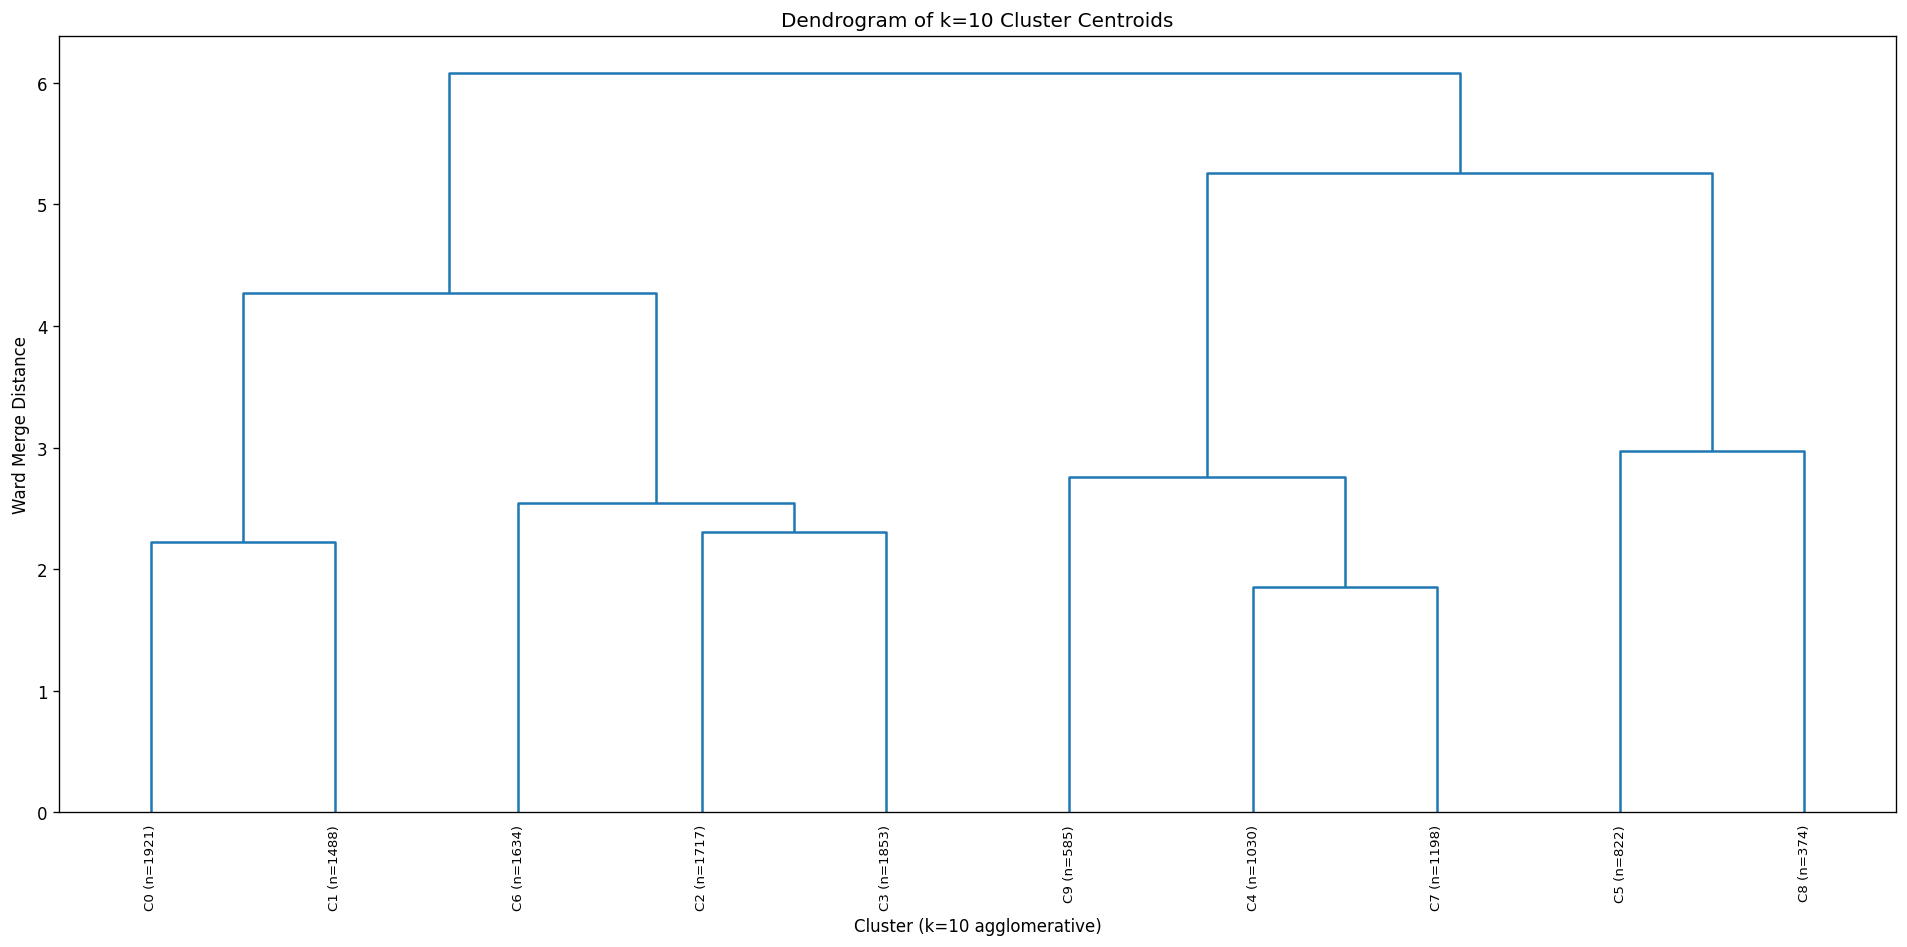

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/dendrogram_k10_centroids.png


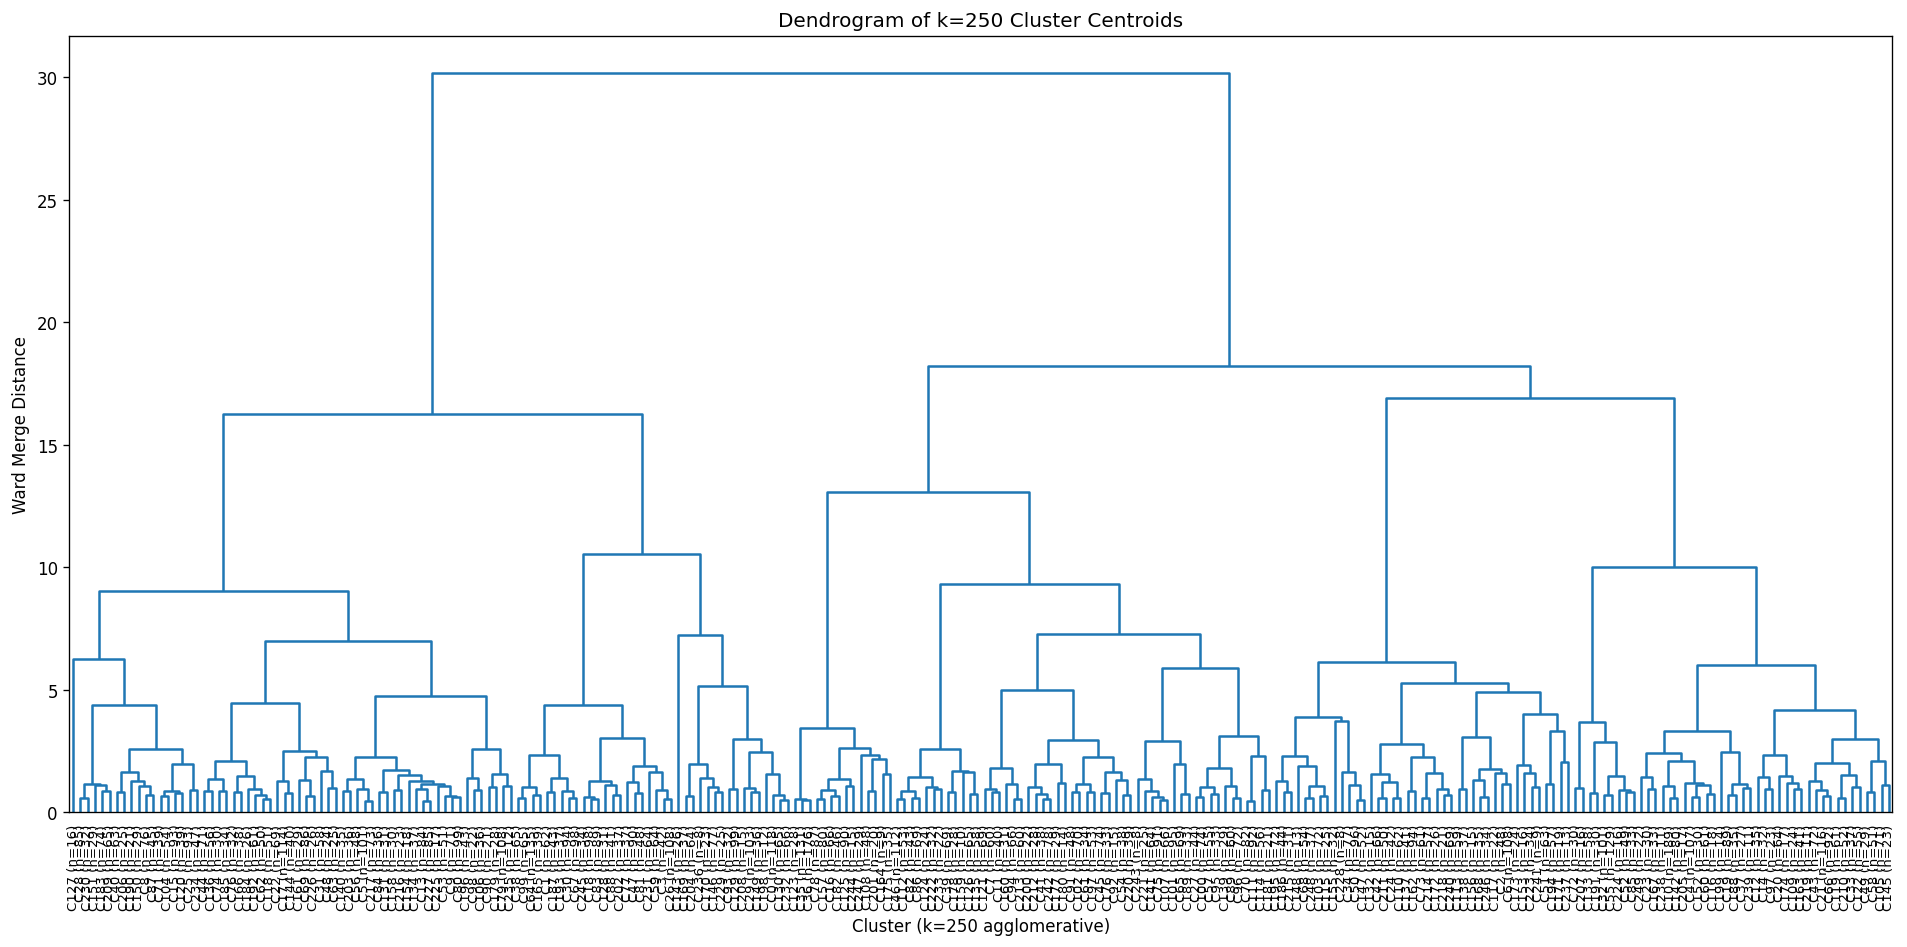

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/dendrogram_k250_centroids.png


In [13]:
# --- Approach A: Truncated Dendrogram (Full Data) ---
# Compute Ward's linkage on all 10D UMAP embeddings.
# This produces the full merge tree for all 12,622 indicators.
print('Computing Ward linkage on all indicators (this may take a minute)...')
Z = linkage(embeddings_10d, method='ward')
print(f'Linkage matrix shape: {Z.shape}')  # (n-1, 4)
print(f'Final merge distance: {Z[-1, 2]:.2f}')

# Truncated dendrogram: show only the last 50 merges.
# Each leaf in this view represents a pre-formed cluster of points,
# with the cluster size shown in parentheses.
fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(
    Z,
    truncate_mode='lastp',
    p=50,  # show last 50 merges
    leaf_rotation=90,
    leaf_font_size=8,
    ax=ax,
    color_threshold=0,  # uniform color for clarity
)
ax.set_xlabel('Cluster (size shown in parentheses)')
ax.set_ylabel('Ward Merge Distance')
ax.set_title('Truncated Dendrogram — Last 50 Merges (All 12,622 Indicators)')

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'dendrogram_truncated_top50.png', dpi=150,
            bbox_inches='tight')
plt.show()
print(f'Saved: {FIGURES_DIR / "dendrogram_truncated_top50.png"}')

# --- Approach B: Dendrogram of k=34 Cluster Centroids ---
# Compute the centroid (mean embedding) of each of the 34 agglomerative clusters,
# then run hierarchical clustering on those 34 centroids.
k34_labels = agglo_labels_dict[34]
centroids_34 = np.array([
    embeddings_10d[k34_labels == cl].mean(axis=0)
    for cl in range(34)
])
cluster_sizes_34 = [int((k34_labels == cl).sum()) for cl in range(34)]
centroid_labels = [f'C{cl} (n={sz})' for cl, sz in enumerate(cluster_sizes_34)]

print(f'\nCentroid matrix shape: {centroids_34.shape}')  # (34, 10)

# Hierarchical clustering on the 34 centroids
Z_centroids = linkage(centroids_34, method='ward')

fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(
    Z_centroids,
    labels=centroid_labels,
    leaf_rotation=90,
    leaf_font_size=8,
    ax=ax,
    color_threshold=0,
)
ax.set_xlabel('Cluster (k=34 agglomerative)')
ax.set_ylabel('Ward Merge Distance')
ax.set_title('Dendrogram of k=34 Cluster Centroids')

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'dendrogram_k34_centroids.png', dpi=150,
            bbox_inches='tight')
plt.show()
print(f'Saved: {FIGURES_DIR / "dendrogram_k34_centroids.png"}')

# --- Approach C: Centroid dendrograms for other selected k values ---
# For each selected k value other than 34 (already covered by Approach B),
# compute cluster centroids and build a dendrogram.
for sel_k in selected_k_values:
    if sel_k == 34:
        continue  # already produced in Approach B

    sel_labels = agglo_labels_dict[sel_k]
    n_sel_clusters = len(set(sel_labels))
    centroids_sel = np.array([
        embeddings_10d[sel_labels == cl].mean(axis=0)
        for cl in range(n_sel_clusters)
    ])
    sizes_sel = [int((sel_labels == cl).sum()) for cl in range(n_sel_clusters)]
    labels_sel = [f'C{cl} (n={sz})' for cl, sz in enumerate(sizes_sel)]

    Z_sel = linkage(centroids_sel, method='ward')

    fig, ax = plt.subplots(figsize=(16, 8))
    dendrogram(
        Z_sel,
        labels=labels_sel,
        leaf_rotation=90,
        leaf_font_size=8,
        ax=ax,
        color_threshold=0,
    )
    ax.set_xlabel(f'Cluster (k={sel_k} agglomerative)')
    ax.set_ylabel('Ward Merge Distance')
    ax.set_title(f'Dendrogram of k={sel_k} Cluster Centroids')

    plt.tight_layout()
    fig.savefig(FIGURES_DIR / f'dendrogram_k{sel_k}_centroids.png', dpi=150,
                bbox_inches='tight')
    plt.show()
    print(f'Saved: {FIGURES_DIR / f"dendrogram_k{sel_k}_centroids.png"}')

---
## Section 5: Cluster Visualization

We visualize the clustering results for the selected agglomerative k values and the
best HDBSCAN run:

1. **Selected agglomerative k values** — the values chosen in Part B above
   (k=8 coarse reference, k=10 local optimum, k=34 mid-range, k=250 fine-grained)
2. **Best HDBSCAN** — the best density-based result by silhouette score

Each visualization is a scatter plot of the 2D UMAP projection colored by cluster
assignment. This provides a visual check of whether clusters occupy coherent regions
of the embedding space. Per-type overlays (coloring by known wordplay types) are
deferred to Notebook 06, where labeled evaluation is performed.

### Visualization Helper Functions

In [14]:
def plot_clusters(embeddings_2d, labels, title, filename, noise_label=-1):
    """Scatter plot of 2D UMAP colored by cluster assignment."""
    fig, ax = plt.subplots(figsize=(12, 9))

    # Plot noise points first (gray, small)
    noise_mask = labels == noise_label
    if noise_mask.any():
        ax.scatter(
            embeddings_2d[noise_mask, 0],
            embeddings_2d[noise_mask, 1],
            s=1, alpha=0.15, color='lightgray', label='noise', zorder=1
        )

    # Plot clustered points
    non_noise_mask = ~noise_mask
    unique_labels = sorted(set(labels[non_noise_mask]))
    n_clusters = len(unique_labels)

    # Use a colormap with enough distinct colors
    cmap = plt.cm.get_cmap('tab20', max(n_clusters, 20))
    for i, cl in enumerate(unique_labels):
        mask = labels == cl
        ax.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            s=2, alpha=0.4, color=cmap(i % 20), zorder=2
        )

    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title(f'{title} ({n_clusters} clusters)')

    if noise_mask.any():
        n_noise = noise_mask.sum()
        ax.annotate(f'Noise: {n_noise} ({n_noise/len(labels)*100:.1f}%)',
                    xy=(0.02, 0.98), xycoords='axes fraction',
                    fontsize=9, va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    fig.savefig(FIGURES_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {FIGURES_DIR / filename}')

### Selected Agglomerative Visualizations

/var/folders/3k/s3lth05j71x9zqxntyjngc0c0000gn/T/ipykernel_6340/4156939200.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max(n_clusters, 20))


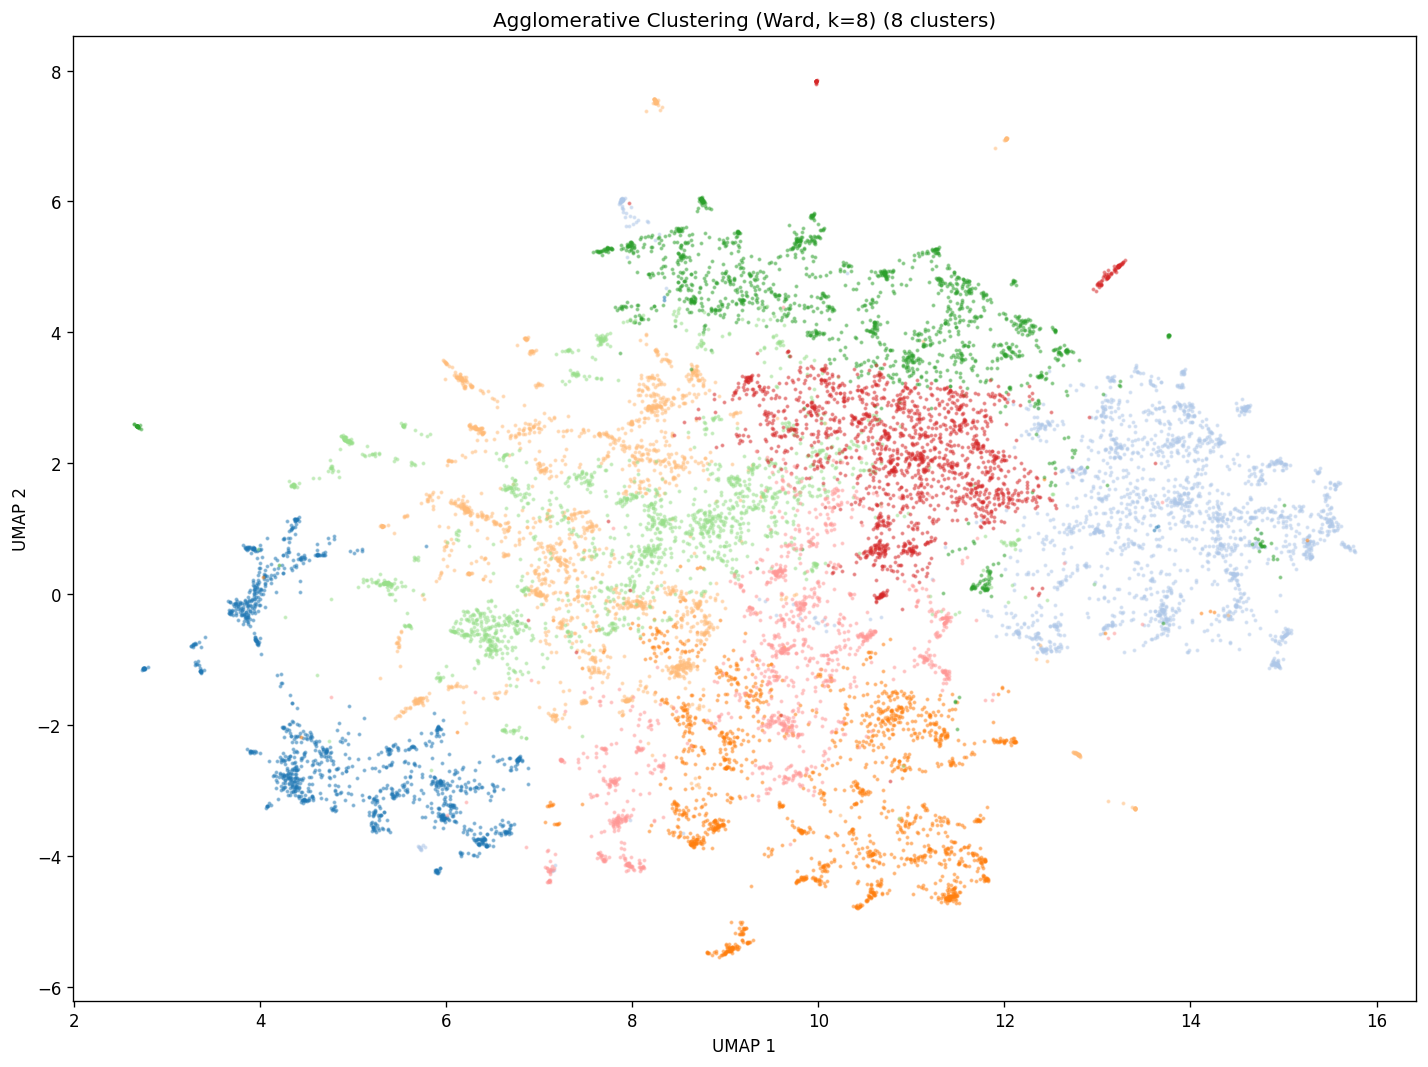

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/agglo_k8_clusters.png


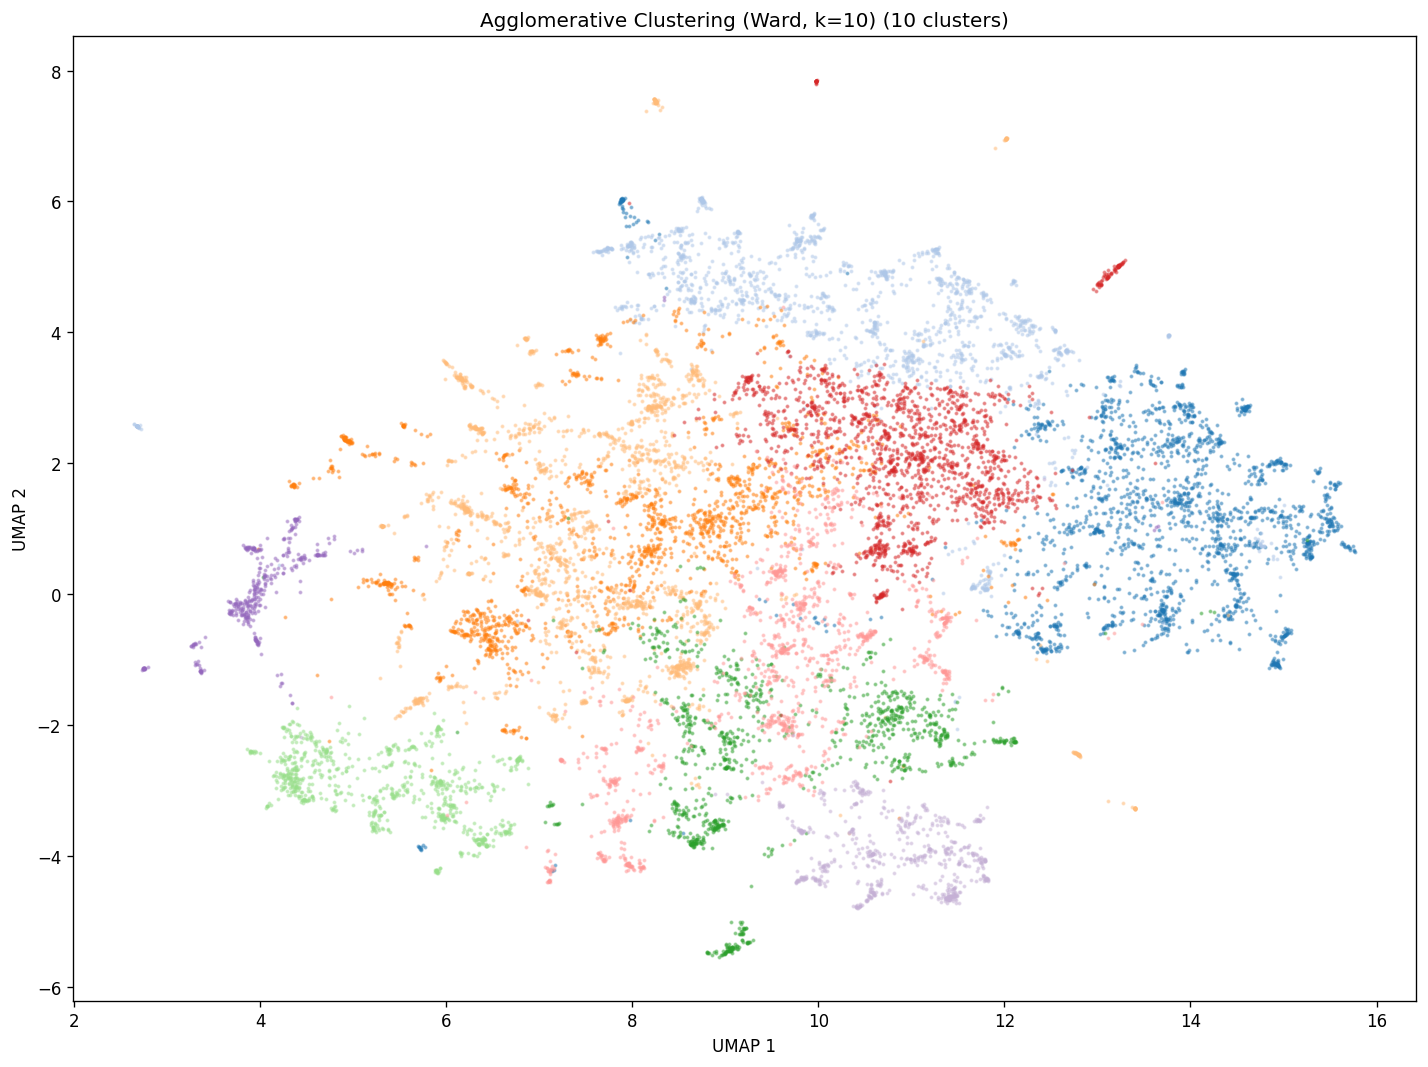

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/agglo_k10_clusters.png


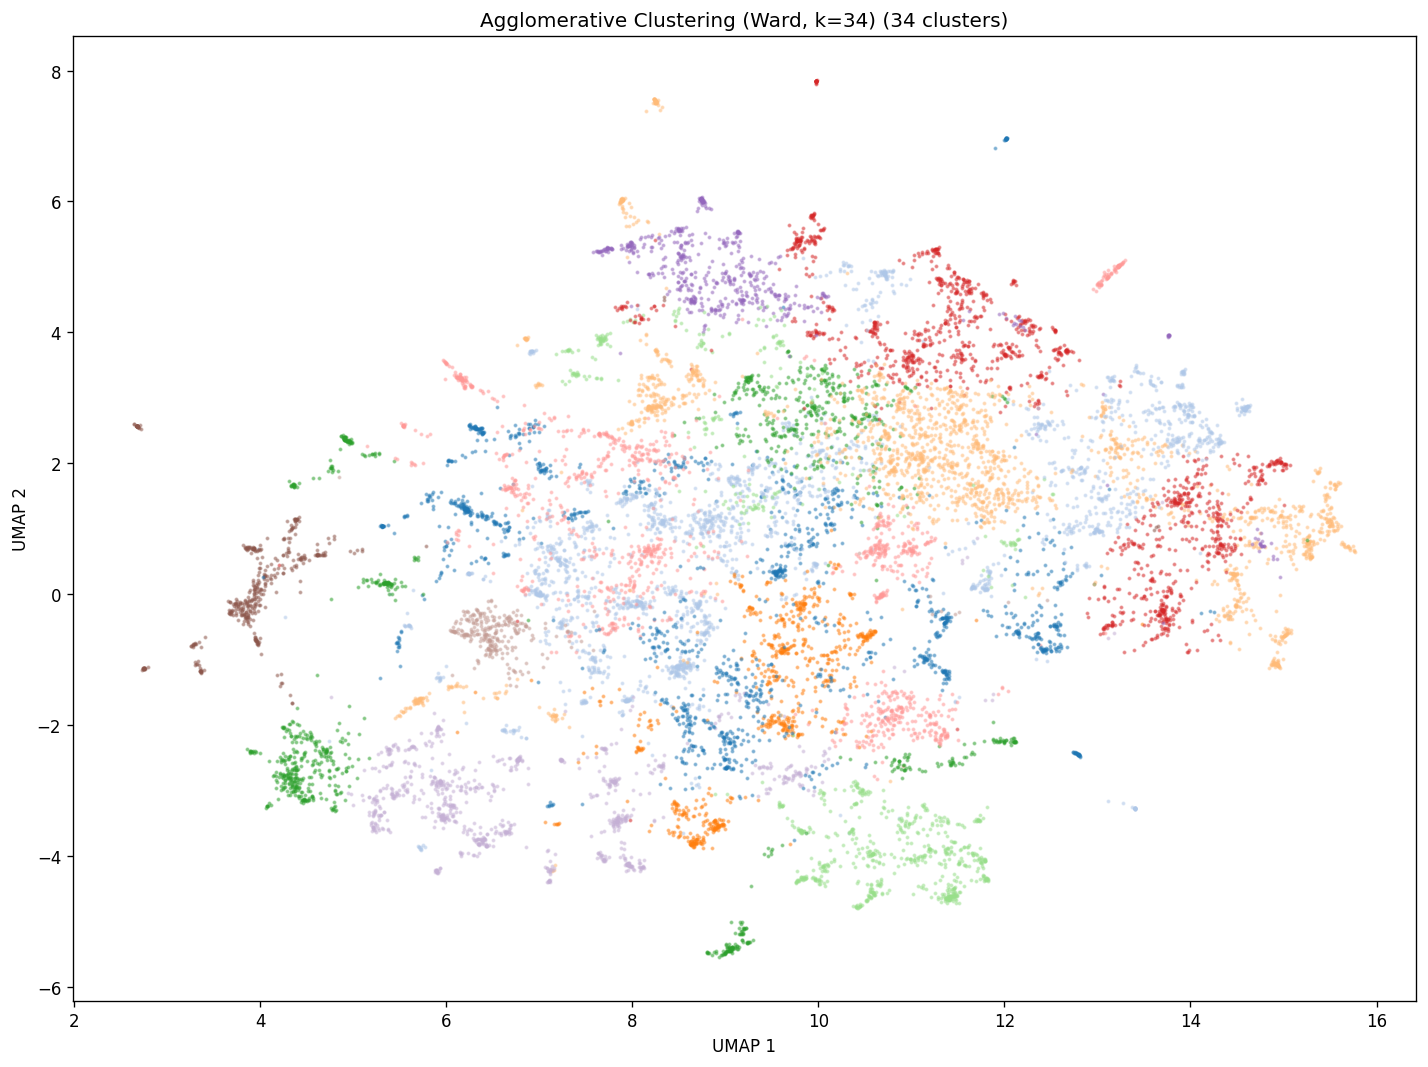

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/agglo_k34_clusters.png


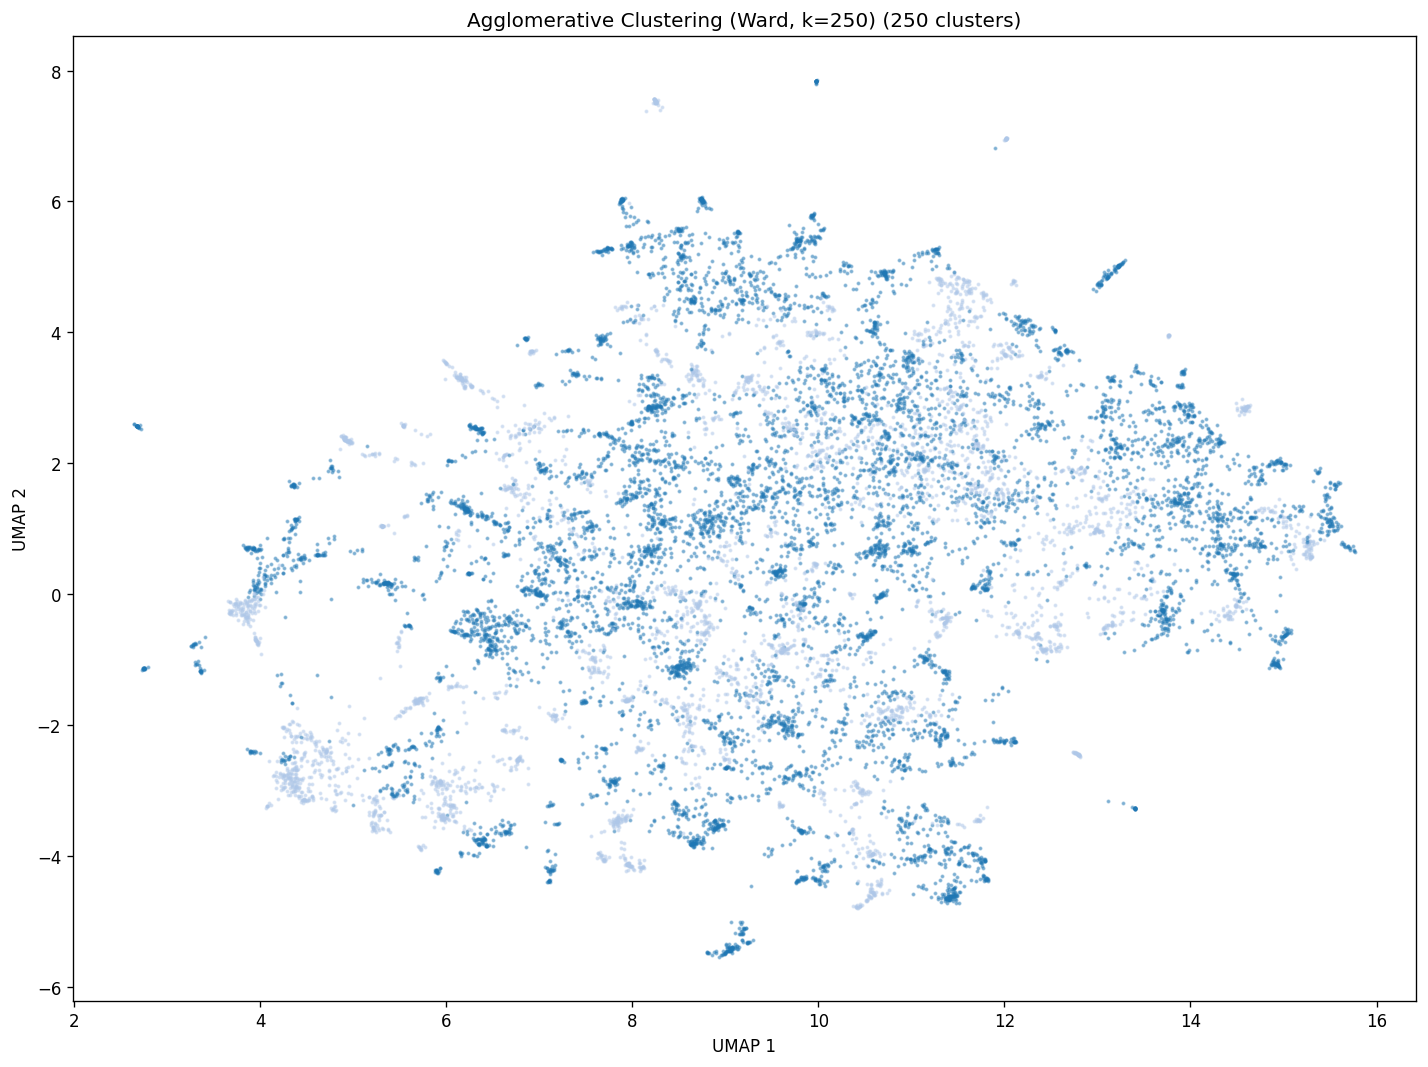

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/agglo_k250_clusters.png


In [15]:
for k in selected_k_values:
    plot_clusters(
        embeddings_2d,
        agglo_labels_dict[k],
        title=f'Agglomerative Clustering (Ward, k={k})',
        filename=f'agglo_k{k}_clusters.png'
    )

### Best HDBSCAN Visualization

/var/folders/3k/s3lth05j71x9zqxntyjngc0c0000gn/T/ipykernel_6340/4156939200.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max(n_clusters, 20))


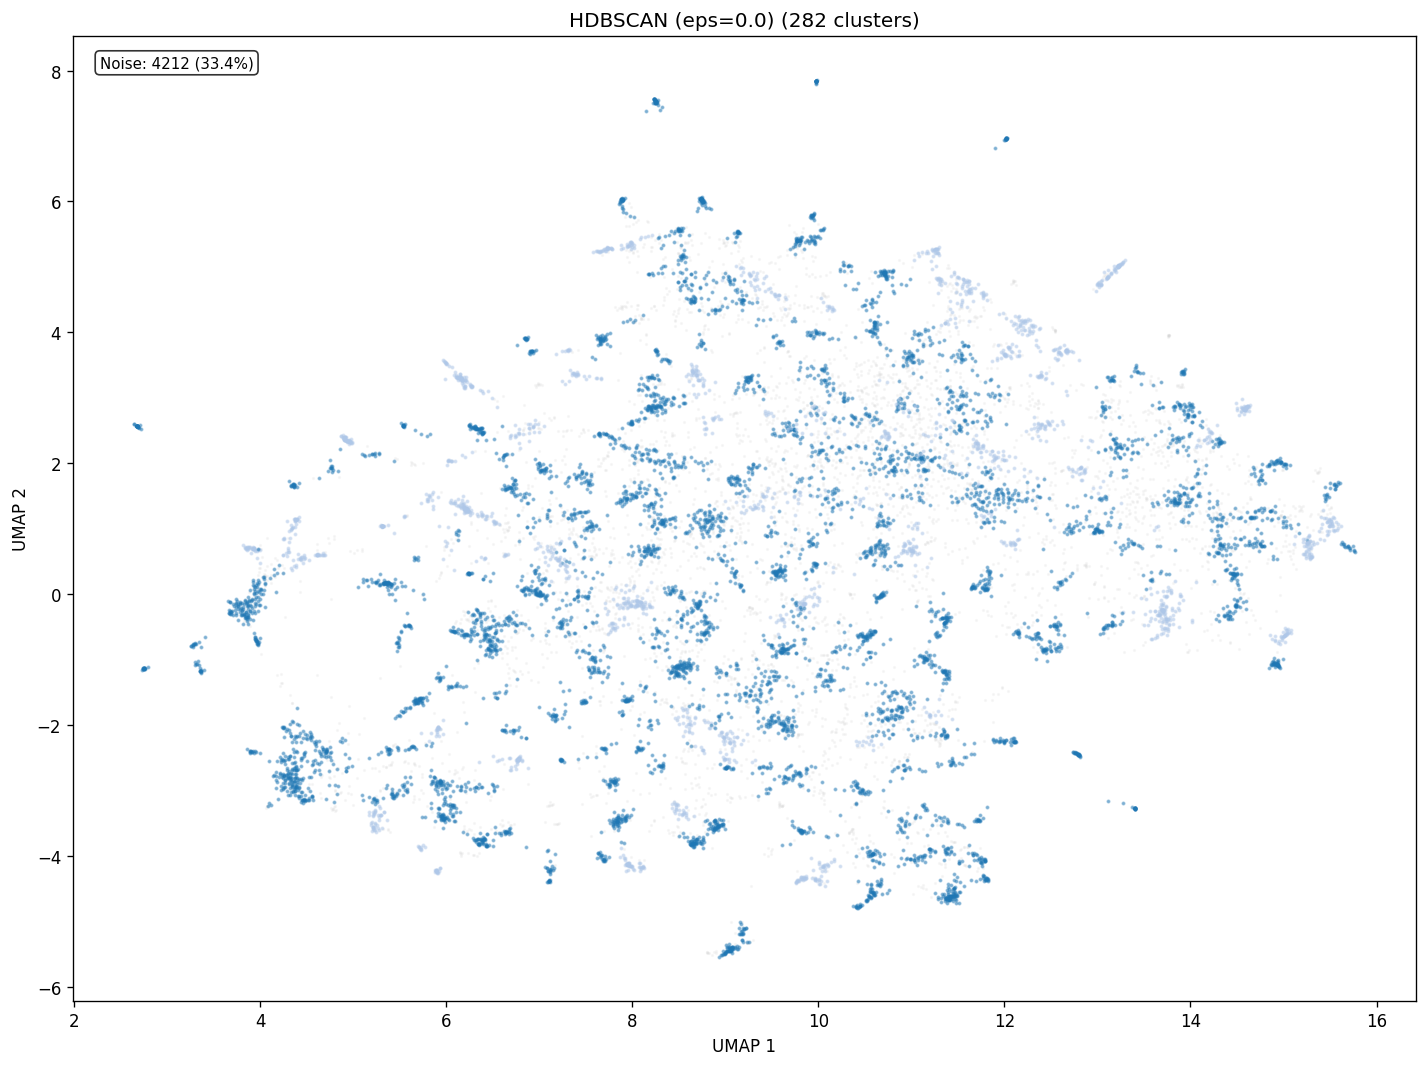

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/hdbscan_best_clusters.png


In [16]:
plot_clusters(
    embeddings_2d,
    best_hdbscan_labels,
    title=f'HDBSCAN (eps={best_eps})',
    filename='hdbscan_best_clusters.png'
)

---
## Section 6: Qualitative Inspection

For each of the selected agglomerative k values and the best HDBSCAN run, we print the
10 indicators closest to the cluster centroid (in 10D UMAP space). This label-free
inspection lets us judge whether clusters are semantically coherent — do the nearest-
to-centroid indicators share a recognizable theme? — without importing any wordplay
type labels. Label-based evaluation is deferred to Notebooks 05 and 06.

In [17]:
def inspect_clusters(labels, embeddings_10d, indicator_names, method_name,
                     n_examples=10):
    """Print centroid-nearest indicators and cluster size per cluster.

    This is a label-free inspection: we look at which indicator strings are
    closest to each cluster's centroid to judge semantic coherence.
    """
    unique_labels = sorted(set(labels))

    for cl in unique_labels:
        if cl == -1:
            # Summarize noise points briefly
            n_noise = (labels == -1).sum()
            print(f'\n{"=" * 60}')
            print(f'{method_name} — Noise points: {n_noise}')
            print(f'{"=" * 60}')
            continue

        mask = labels == cl
        cluster_size = mask.sum()
        cluster_embeddings = embeddings_10d[mask]
        cluster_names = indicator_names[mask]

        # Compute centroid and find nearest points
        centroid = cluster_embeddings.mean(axis=0)
        dists_to_centroid = np.linalg.norm(cluster_embeddings - centroid, axis=1)
        nearest_idx = np.argsort(dists_to_centroid)[:n_examples]
        nearest = [cluster_names[i] for i in nearest_idx]

        print(f'\n{"=" * 60}')
        print(f'{method_name} — Cluster {cl} (n={cluster_size})')
        print(f'{"-" * 60}')
        print(f'Nearest to centroid: {", ".join(nearest)}')

### Selected Agglomerative — Cluster Inspection

In [18]:
for k in selected_k_values:
    print(f'\n{"#" * 60}')
    print(f'  k = {k}')
    print(f'{"#" * 60}')
    inspect_clusters(
        agglo_labels_dict[k],
        embeddings_10d,
        indicator_names,
        method_name=f'Agglomerative k={k}'
    )


############################################################
  k = 8
############################################################

Agglomerative k=8 — Cluster 0 (n=1196)
------------------------------------------------------------
Nearest to centroid: in rehab, cured, recovered from, after resettlement, following rehab, rediscovered, retrieving, recovered, retrieved, recovery

Agglomerative k=8 — Cluster 1 (n=1921)
------------------------------------------------------------
Nearest to centroid: profligate, perverse, perversely, travesty, preposterous, promiscuously, promiscuous, pervertedly, precariously, errant

Agglomerative k=8 — Cluster 2 (n=1615)
------------------------------------------------------------
Nearest to centroid: as an anagram, anagram, anagrams, as a, as herbal, cast of, as a show of, cast in, featured, cast

Agglomerative k=8 — Cluster 3 (n=1853)
------------------------------------------------------------
Nearest to centroid: must encase, must be caught, into ca

### Best HDBSCAN — Cluster Inspection

HDBSCAN may produce many clusters. We inspect the 15 largest clusters to keep
output manageable. A full inspection of all clusters belongs in Notebook 05.

In [19]:
# For HDBSCAN, inspect only the largest clusters to keep output concise
unique_hdbscan_labels = sorted(set(best_hdbscan_labels))
n_hdbscan_clusters = len([l for l in unique_hdbscan_labels if l != -1])

if n_hdbscan_clusters > 15:
    # Find the 15 largest clusters by size
    cluster_sizes = pd.Series(best_hdbscan_labels[best_hdbscan_labels != -1]).value_counts()
    top_15_labels = set(cluster_sizes.head(15).index)

    # Create a filtered label array: keep top 15, set rest to -1
    filtered_labels = np.where(
        np.isin(best_hdbscan_labels, list(top_15_labels)),
        best_hdbscan_labels,
        -1
    )
    print(f'HDBSCAN found {n_hdbscan_clusters} clusters. '
          f'Showing the 15 largest below.')
    inspect_clusters(
        filtered_labels,
        embeddings_10d,
        indicator_names,
        method_name=f'HDBSCAN (eps={best_eps})'
    )
else:
    inspect_clusters(
        best_hdbscan_labels,
        embeddings_10d,
        indicator_names,
        method_name=f'HDBSCAN (eps={best_eps})'
    )

HDBSCAN found 282 clusters. Showing the 15 largest below.

HDBSCAN (eps=0.0) — Noise points: 11084

HDBSCAN (eps=0.0) — Cluster 21 (n=133)
------------------------------------------------------------
Nearest to centroid: bringing back, to return, getting back, to bring back, to come back, to return in, to get back, about to go back, coming back in, needing to go back

HDBSCAN (eps=0.0) — Cluster 28 (n=69)
------------------------------------------------------------
Nearest to centroid: turned, turned to, gets turned, turn to, turning, turning turtle, stomach turning, having turned, after turning, in turn

HDBSCAN (eps=0.0) — Cluster 51 (n=273)
------------------------------------------------------------
Nearest to centroid: getting reinvented, retrofit, being reselected, retuned, to be reappointed to, reinvention, redesign, being rebuilt, rebuilt, retrained

HDBSCAN (eps=0.0) — Cluster 53 (n=64)
------------------------------------------------------------
Nearest to centroid: changes, 

---
## Section 7: Save All Outputs

We save cluster labels for every run so that downstream notebooks can load and evaluate
them without rerunning the clustering. Each CSV has columns `indicator` and `cluster_label`.

**Output files:**

| File | Location | Description |
|------|----------|-------------|
| `cluster_labels_hdbscan_eps_{value}.csv` | `DATA_DIR` | Labels per HDBSCAN epsilon run |
| `cluster_labels_agglo_k{value}.csv` | `DATA_DIR` | Labels per agglomerative k (all swept values) |
| `clustering_metrics_summary.csv` | `OUTPUT_DIR` | All metrics from all runs |
| `pairwise_distance_distribution.png` | `FIGURES_DIR` | Distance histogram |
| `hdbscan_epsilon_sensitivity.png` | `FIGURES_DIR` | HDBSCAN sensitivity analysis |
| `agglo_metrics_vs_k.png` | `FIGURES_DIR` | Agglomerative metrics vs k plot |
| `agglo_k{value}_clusters.png` | `FIGURES_DIR` | Scatter plots for selected k values |
| `hdbscan_best_clusters.png` | `FIGURES_DIR` | Best HDBSCAN scatter plot |
| `dendrogram_truncated_top50.png` | `FIGURES_DIR` | Truncated dendrogram (full data) |
| `dendrogram_k34_centroids.png` | `FIGURES_DIR` | Dendrogram of k=34 centroids |
| `dendrogram_k{k}_centroids.png` | `FIGURES_DIR` | Centroid dendrograms for each selected k ≠ 34 |

In [20]:
# Save HDBSCAN cluster labels for each epsilon
for eps, labels in hdbscan_labels_dict.items():
    eps_str = f'{eps:.4f}'.replace('.', 'p')  # e.g., 0.1500 -> 0p1500
    fname = f'cluster_labels_hdbscan_eps_{eps_str}.csv'
    out_df = pd.DataFrame({
        'indicator': indicator_names,
        'cluster_label': labels,
    })
    out_df.to_csv(DATA_DIR / fname, index=False)
    print(f'Saved: {fname}')

Saved: cluster_labels_hdbscan_eps_0p0000.csv
Saved: cluster_labels_hdbscan_eps_0p2140.csv
Saved: cluster_labels_hdbscan_eps_0p4280.csv
Saved: cluster_labels_hdbscan_eps_0p6420.csv
Saved: cluster_labels_hdbscan_eps_0p7788.csv
Saved: cluster_labels_hdbscan_eps_0p8560.csv
Saved: cluster_labels_hdbscan_eps_1p0700.csv
Saved: cluster_labels_hdbscan_eps_1p2840.csv
Saved: cluster_labels_hdbscan_eps_1p4980.csv
Saved: cluster_labels_hdbscan_eps_1p9327.csv
Saved: cluster_labels_hdbscan_eps_2p2334.csv
Saved: cluster_labels_hdbscan_eps_2p4729.csv
Saved: cluster_labels_hdbscan_eps_2p6847.csv


In [21]:
# Save agglomerative cluster labels for each k
for k, labels in agglo_labels_dict.items():
    fname = f'cluster_labels_agglo_k{k}.csv'
    out_df = pd.DataFrame({
        'indicator': indicator_names,
        'cluster_label': labels,
    })
    out_df.to_csv(DATA_DIR / fname, index=False)
    print(f'Saved: {fname}')

Saved: cluster_labels_agglo_k4.csv
Saved: cluster_labels_agglo_k6.csv
Saved: cluster_labels_agglo_k8.csv
Saved: cluster_labels_agglo_k9.csv
Saved: cluster_labels_agglo_k10.csv
Saved: cluster_labels_agglo_k11.csv
Saved: cluster_labels_agglo_k12.csv
Saved: cluster_labels_agglo_k16.csv
Saved: cluster_labels_agglo_k20.csv
Saved: cluster_labels_agglo_k26.csv
Saved: cluster_labels_agglo_k34.csv
Saved: cluster_labels_agglo_k50.csv
Saved: cluster_labels_agglo_k75.csv
Saved: cluster_labels_agglo_k100.csv
Saved: cluster_labels_agglo_k150.csv
Saved: cluster_labels_agglo_k200.csv
Saved: cluster_labels_agglo_k250.csv


In [22]:
# Build a combined metrics summary for all runs
all_metrics = []

# HDBSCAN runs
for _, row in df_hdbscan.iterrows():
    all_metrics.append({
        'method': 'HDBSCAN',
        'parameters': f'min_cluster_size=10, eps={row["epsilon"]}',
        'n_clusters': int(row['n_clusters']),
        'n_noise': int(row['n_noise']),
        'noise_pct': row['noise_pct'],
        'silhouette': row['silhouette'],
        'davies_bouldin': row['davies_bouldin'],
        'calinski_harabasz': float('nan'),  # not computed for HDBSCAN (noise points)
    })

# Agglomerative runs
for _, row in df_agglo.iterrows():
    all_metrics.append({
        'method': 'Agglomerative (Ward)',
        'parameters': f'k={int(row["k"])}',
        'n_clusters': int(row['k']),
        'n_noise': 0,
        'noise_pct': 0.0,
        'silhouette': row['silhouette'],
        'davies_bouldin': row['davies_bouldin'],
        'calinski_harabasz': row['calinski_harabasz'],
    })

df_all_metrics = pd.DataFrame(all_metrics)
metrics_path = OUTPUT_DIR / 'clustering_metrics_summary.csv'
df_all_metrics.to_csv(metrics_path, index=False)

print(f'Saved: {metrics_path}')
print(f'\n--- Full Metrics Summary ---')
print(df_all_metrics.to_string(index=False))

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/clustering_metrics_summary.csv

--- Full Metrics Summary ---
              method                      parameters  n_clusters  n_noise  noise_pct  silhouette  davies_bouldin  calinski_harabasz
             HDBSCAN    min_cluster_size=10, eps=0.0         282     4212  33.370306    0.630992        0.470028                NaN
             HDBSCAN  min_cluster_size=10, eps=0.214         244     3783  29.971478    0.584483        0.508532                NaN
             HDBSCAN  min_cluster_size=10, eps=0.428          62     1306  10.347013   -0.117756        1.047558                NaN
             HDBSCAN  min_cluster_size=10, eps=0.642          17      313   2.479797   -0.296464        0.976518                NaN
             HDBSCAN min_cluster_size=10, eps=0.7788          11      114   0.903185   -0.185984        0.775157                NaN
             HDBSCAN  min_cluster_size=10, eps=0.856          10      

In [23]:
# Final file listing
print('=== All Output Files ===')
print(f'\nCluster labels (in {DATA_DIR}):')
for f in sorted(DATA_DIR.glob('cluster_labels_*.csv')):
    print(f'  {f.name}')

print(f'\nMetrics summary (in {OUTPUT_DIR}):')
print(f'  clustering_metrics_summary.csv')

print(f'\nFigures (in {FIGURES_DIR}):')
for f in sorted(FIGURES_DIR.glob('*.png')):
    print(f'  {f.name}')

print('\nDone. All outputs saved for Notebook 05.')

=== All Output Files ===

Cluster labels (in /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/data):
  cluster_labels_agglo_k10.csv
  cluster_labels_agglo_k100.csv
  cluster_labels_agglo_k11.csv
  cluster_labels_agglo_k12.csv
  cluster_labels_agglo_k150.csv
  cluster_labels_agglo_k16.csv
  cluster_labels_agglo_k20.csv
  cluster_labels_agglo_k200.csv
  cluster_labels_agglo_k250.csv
  cluster_labels_agglo_k26.csv
  cluster_labels_agglo_k34.csv
  cluster_labels_agglo_k4.csv
  cluster_labels_agglo_k50.csv
  cluster_labels_agglo_k6.csv
  cluster_labels_agglo_k75.csv
  cluster_labels_agglo_k8.csv
  cluster_labels_agglo_k9.csv
  cluster_labels_hdbscan_eps_0p0000.csv
  cluster_labels_hdbscan_eps_0p2140.csv
  cluster_labels_hdbscan_eps_0p4280.csv
  cluster_labels_hdbscan_eps_0p6420.csv
  cluster_labels_hdbscan_eps_0p7788.csv
  cluster_labels_hdbscan_eps_0p8560.csv
  cluster_labels_hdbscan_eps_1p0700.csv
  cluster_labels_hdbscan_eps_1p2840.csv
  cluster_labels_hdbscan_eps_1p4980.csv

---
## Interpretation of Results

### HDBSCAN Epsilon Sensitivity

The epsilon sweep — now with finer resolution in the 0-to-5th-percentile range —
confirms a sharp transition with no stable middle ground. At epsilon=0, HDBSCAN finds
many tight clusters but discards roughly a third of points as noise. Even small epsilon
increases cause rapid cluster merging, and by the 5th percentile the clustering has
largely collapsed. The finer-grained sweep does not reveal a hidden plateau — the
transition from many clusters to few is genuinely abrupt.

The high silhouette score at low epsilon is partly an artifact of discarding many points
as noise, as KCT warned. HDBSCAN is only grading itself on the easy cases. Many noise
points form visible clumps in the 2D UMAP projection but fall below the min_cluster_size
threshold or lack sufficient density in the full 10D space.

### Agglomerative Metrics Across k Values

The expanded k sweep (k=4 to k=250) reveals how silhouette and Davies-Bouldin scores
evolve across the full range of granularities. If silhouette continues to improve
monotonically, this confirms that the data's natural structure is very fine-grained —
there is no single "correct" number of clusters. If an elbow appears, it identifies the
data's preferred granularity.

Calinski-Harabasz shows a different pattern, peaking at lower k values. This reflects
the metric's known bias toward fewer clusters rather than a genuine preference for
coarse granularity.

### Qualitative Cluster Coherence

The centroid-nearest inspection at the four selected k values (k=8, 10, 34, 250) reveals
how semantic coherence changes with granularity. At k=8, clusters tend to be broad
mixtures of indicators with different semantic themes. At finer granularities, clusters
become more focused — the nearest-to-centroid indicators increasingly share a
recognizable conceptual theme (e.g., movement words, hearing words, containment words).

### Dendrogram Structure

The dendrograms reveal the hierarchical relationships between clusters. The truncated
dendrogram of the full data shows the merge distances at the top of the tree, indicating
whether there are natural "cut points" — large gaps in merge distance that suggest a
preferred number of clusters. The centroid-based dendrograms at multiple k values show
how clusters merge at different granularities.

### What This Notebook Does NOT Tell Us

This notebook deliberately avoids using wordplay type labels or domain knowledge. We
cannot yet say whether any cluster corresponds to "anagram" or "homophone" — that
evaluation requires comparing cluster assignments to known labels, which happens in
Notebooks 05 and 06. What we can say is:

1. The data has strong local structure at fine granularity
2. The HDBSCAN transition from many clusters to few is abrupt — even with finer
   epsilon resolution, no stable intermediate level emerges
3. The agglomerative metrics-vs-k sweep reveals whether the data has a preferred
   granularity or whether quality improves monotonically
4. Clusters are semantically coherent when examined qualitatively, especially at
   finer granularities

These findings set up the question for Notebook 05: can domain knowledge (seed words,
constrained clustering) help us find wordplay-type-level structure that does not emerge
on its own?